In [224]:
#!pip3 install python-louvain

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import community as community_louvain
import numpy as np
import networkx as nx
from community import community_louvain
from random import sample
from scipy.integrate import odeint
import scipy.sparse as sp
import pandas as pd
import numpy.linalg as lg
import operator
%matplotlib inline
from tabulate import tabulate
from networkx.algorithms import community

In [37]:
G=nx.read_weighted_edgelist('ColoSpg.txt')# Colorado Springs dataset
D=nx.read_weighted_edgelist('Drugs.txt')
Z=nx.read_gml("dolphins.gml")
F=nx.read_gml("lesmis.gml")
ER=nx.erdos_renyi_graph(500,0.024,seed=1)
ER2=nx.erdos_renyi_graph(500,5/500,seed=0)
air=nx.read_weighted_edgelist('USAir 97.txt')
rd=nx.read_weighted_edgelist('road2.txt')
BA=nx.barabasi_albert_graph(100,3,seed=1)
air2=nx.read_edgelist('airline.txt')

In [6]:
nx.average_shortest_path_length(ER)

2.7627174348697396

In [7]:
Z.number_of_selfloops()

0

In [15]:
def matrix(g):# graph matrices
    return nx.to_numpy_matrix(g)

In [18]:
def figure(g): #plotting ntworks
    g=nx.from_numpy_matrix(matrix(g))
    plt.figure(figsize=(18,18))

    a=nx.draw_networkx(g)
    plt.axis('off')
    #plt.savefig("pth2.png")
    plt.show()
    return a

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


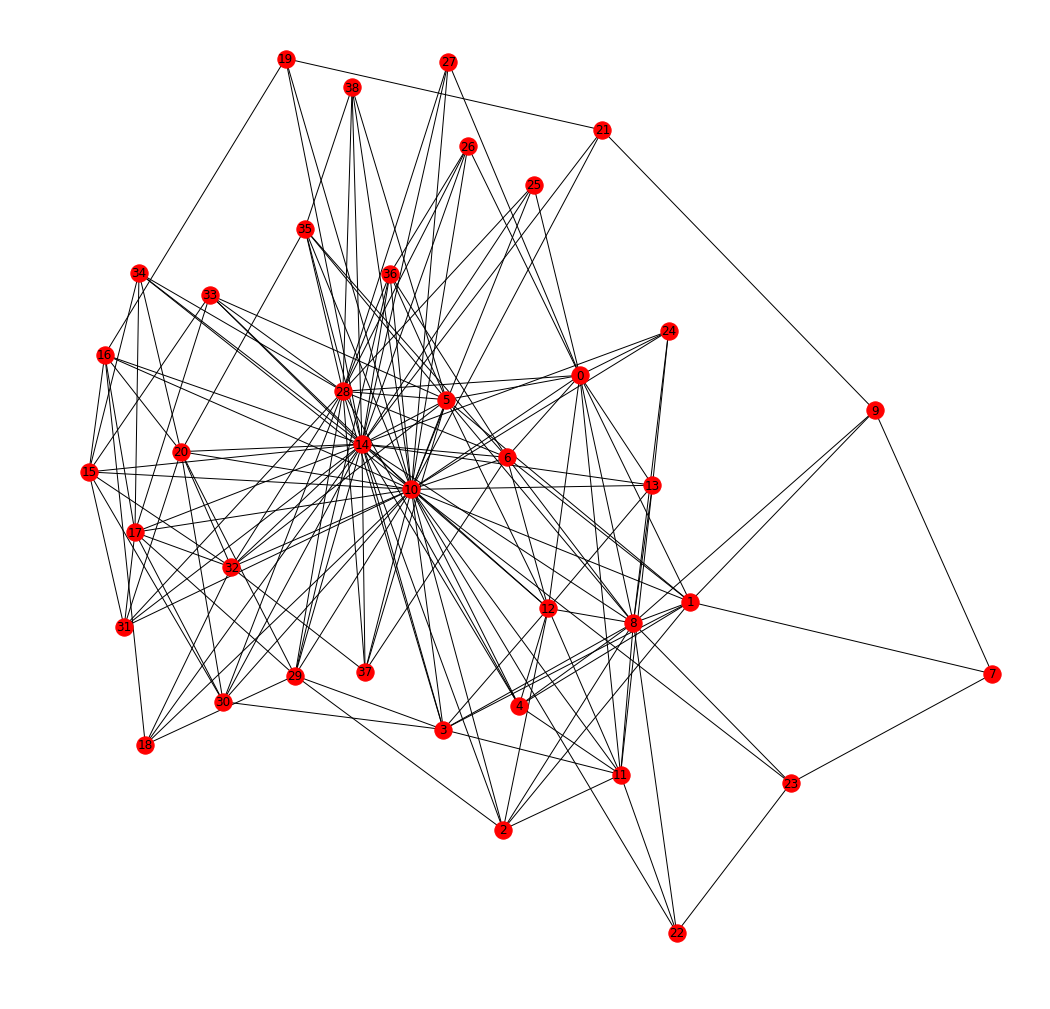

In [19]:
figure(rd)

# NLDS

In [20]:
def epi_step(A, p, n, gamma, beta):
    q = np.zeros(n)
    for i in range(n):
        z = 1
        f,f1,v=sp.find(A[:,i])
        for j in f:
            z = z*(1-beta*p[j]) #zeta
        q[i] = (1-p[i])*z+gamma*p[i]*z # probability of not being infected
    p = 1-q 
    
    return p# probability of  being infected

In [21]:
def trial(A, gamma, beta, m, init):
    t = np.zeros(m)
    n = len(A)
    p=init
    for i in range(m):
        t[i] = sum(p)
        p = epi_step(A, p, n, gamma, beta)
    return t,p

In [346]:
def epidemic(g):
    #for i in range(5):
    m=100
    gamma=.08
    beta=.14
    init = np.zeros(len(matrix(g)))
    init[0] = 1
    t,p1 = trial(matrix(g),gamma,beta,m,init)
    a=plt.plot(range(m),t/len(matrix(g)),'x',label=('no vaccination'))
    #plt.grid()
    #b=plt.legend()
    return a

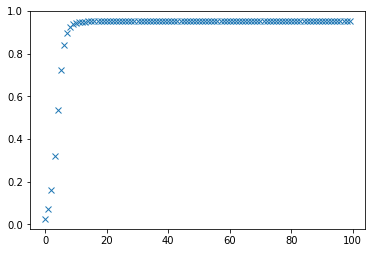

In [51]:
epidemic(rd)

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


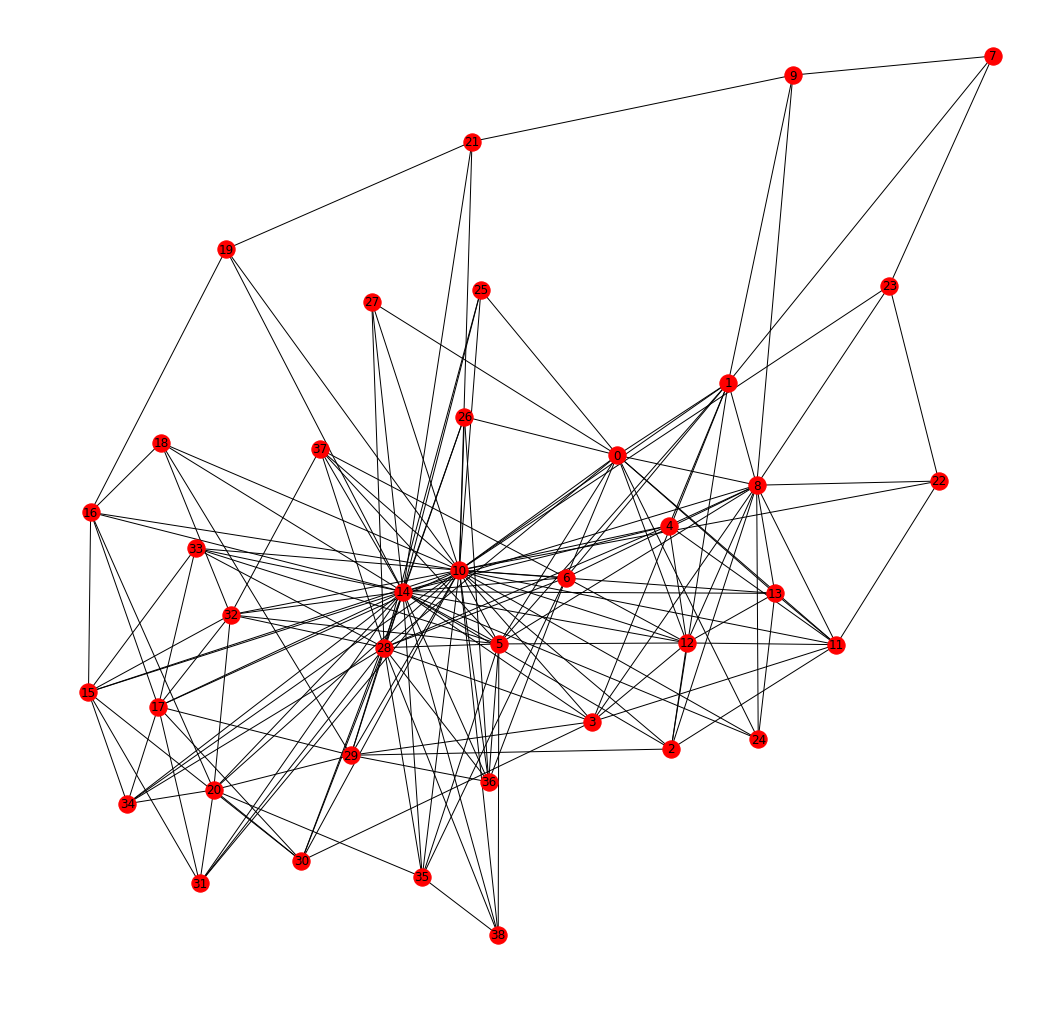

In [52]:
figure(rd)

In [25]:
ER.number_of_edges()

3014

# Vaccinating hubs

In [342]:
def remove_hubs(g):
    deg=np.array(list(dict(g.degree()).values())).astype(float) 
    deg_sort=sorted(deg, reverse=True)#sorting degrees
    mx=deg_sort[:int(0.1*len(g.nodes()))]# 10% of nodes
    a=[]
    for nodes in g.nodes(): # returning hubs
        if g.degree(nodes) in mx:
            a.append(nodes) 
    
    
    gnow=g.copy()
    gnow.remove_nodes_from(a) #removing hubs

    A=nx.to_numpy_matrix(gnow)
    gnow=nx.from_numpy_matrix(A)
    
    #infecting largest component to get maximum infection
    component_subgraph_list = list(nx.connected_component_subgraphs(gnow))
    largest_component= max(component_subgraph_list,key=len)
                                   
    t=nx.degree_centrality(largest_component) #infecting  nodes with highest deg
    sorted_tuples = sorted(t.items(), key=operator.itemgetter(1),reverse=True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    p=list(sorted_dict.keys()) 
    q=p[:5] # averaging on 5 graphs starting at different  nodes
    s=[]
    for i in q: #ndls
        m=100
        gamma=.08
        beta=.14
        init = np.zeros(len(A))
        init[int(i)] = 1
        t,p1 = trial(A,gamma,beta,m,init)
        s.append(t)
        c=np.mean(s, axis=0)
    r=plt.plot(range(m),c/len( matrix(g)),'r',label=('hubs_vaccine'))
# #     plt.figure(figsize=(18,18))

#     b=nx.draw_networkx(gnow)
#     plt.axis('off')
#     #plt.savefig("pth2.png")
#     plt.show()
    return r


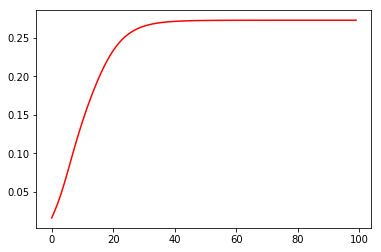

In [343]:
remove_hubs(Z)

# Random Vaccination

In [55]:
def remove_random(g):
    ran= sample(list(g.nodes()), int(0.1*len(g.nodes()))) #seleting random nodes
    
    gnow=g.copy()
    gnow.remove_nodes_from(ran) #removing nodes

    A=nx.to_numpy_matrix(gnow)
    gnow=nx.from_numpy_matrix(A) 
    
    #infecting the largest component
    component_subgraph_list = list(nx.connected_component_subgraphs(gnow))
    largest_component= max(component_subgraph_list,key=len)
                                   
    t=nx.degree_centrality(largest_component)
    sorted_tuples = sorted(t.items(), key=operator.itemgetter(1),reverse=True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    p=list(sorted_dict.keys()) 
    q=p[:5] # getting 5 starting points
    s=[]
    for i in q:
        m=100
        gamma=.08
        beta=.14
        init = np.zeros(len(A))
        init[int(i)] = 1
        t,p1 = trial(A,gamma,beta,m,init)
        s.append(t)
        c=np.mean(s, axis=0)#averaging over the 5 graphs
    r=plt.plot(range(m),c/len( matrix(g)),'b',label=('random_vaccine'))

    return r
#     plt.figure(figsize=(18,18))

#     b=nx.draw_networkx(gnow)
#     plt.axis('off')
    #plt.savefig("pth2.png")
#     plt.show()
#     return b

# Node Betweenness

In [338]:
def remove_node_btwn(g):
    d=nx.betweenness_centrality(g) #
    sorted_tuples = sorted(d.items(), key=operator.itemgetter(1),reverse=True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    e=list(sorted_dict.keys()) 
    f=e[:int(0.1*len(g.nodes()))] # 10% nodes with highest betweenness
    
    gnow=g.copy()
    gnow.remove_nodes_from(f)

    A=nx.to_numpy_matrix(gnow)
    gnow=nx.from_numpy_matrix(A) 
    
    # infecting central node in largest component
    component_subgraph_list = list(nx.connected_component_subgraphs(gnow))
    largest_component= max(component_subgraph_list,key=len)
                                   
    t=nx.degree_centrality(largest_component)
    sorted_tuples = sorted(t.items(), key=operator.itemgetter(1),reverse=True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    p=list(sorted_dict.keys()) 
    q=p[:5]
    s=[]
    for i in q:
        m=100
        gamma=.08
        beta=.14
        init = np.zeros(len(A))
        init[int(i)] = 1
        t,p1 = trial(A,gamma,beta,m,init)
        s.append(t)
        c=np.mean(s, axis=0)
    r=plt.plot(range(m),c/len( matrix(g)),'k',label=('node_betweenness_vaccine'))
# #     plt.figure(figsize=(18,18))

#     b=nx.draw_networkx(gnow)
#     plt.axis('off')
#     #plt.savefig("pth2.png")
#     plt.show()
    return r

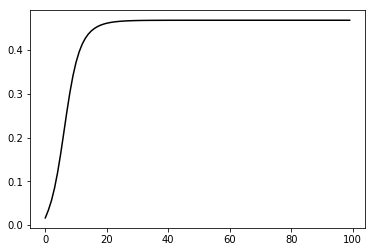

In [339]:
remove_node_btwn(Z)

# Eigen Centrality

In [166]:
def remove_eigen(g):
    d=nx.eigenvector_centrality_numpy(g) # sorting nodes using eigenvecctor centrality
    sorted_tuples = sorted(d.items(), key=operator.itemgetter(1),reverse=True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    e=list(sorted_dict.keys()) 
    f=e[:int(0.5*len(g.nodes()))] #highest 10%
    
    gnow=g.copy()
    gnow.remove_nodes_from(f)
    A=nx.to_numpy_matrix(gnow)
    gnow=nx.from_numpy_matrix(A) 
    # infecting central node in largest component
    component_subgraph_list = list(nx.connected_component_subgraphs(gnow))
    largest_component= max(component_subgraph_list,key=len)
                                   
    t=nx.degree_centrality(largest_component)
    sorted_tuples = sorted(t.items(), key=operator.itemgetter(1),reverse=True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    p=list(sorted_dict.keys()) 
    q=p[:5]
    s=[]
    for i in q:
        m=100
        gamma=.08
        beta=.14
        init = np.zeros(len(A))
        init[int(i)] = 1
        t,p1 = trial(A,gamma,beta,m,init)
        s.append(t)
        c=np.mean(s, axis=0)
    r=plt.plot(range(m),c/len( matrix(g)),'g',label=('eigen_vaccine'))
# #     plt.figure(figsize=(18,18))

#     b=nx.draw_networkx(gnow)
#     plt.axis('off')
#     #plt.savefig("pth2.png")
#     plt.show()

    return r

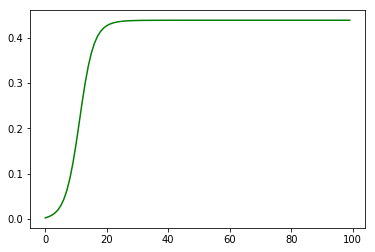

In [167]:
remove_eigen(ER)

# Acquaintance Vaccination

In [58]:
def acquintance(g):
    a=sample(list(g.nodes()), int(0.1*len(g.nodes())))# selecting random node
    k=[]
    for i in a: #selecting neighbour of the random node
        b=sample(list(g.neighbors(i)), 1)
        k.append(b)
    f = []
    for sublist in k: #unpacking list of lists
        for node in sublist:
            f.append(node)
    gnow=g.copy()
    gnow.remove_nodes_from(f)

    A=nx.to_numpy_matrix(gnow)
    gnow=nx.from_numpy_matrix(A) 
    #infecting the largest component
    component_subgraph_list = list(nx.connected_component_subgraphs(gnow))
    largest_component= max(component_subgraph_list,key=len)
                                   
    t=nx.degree_centrality(largest_component)
    sorted_tuples = sorted(t.items(), key=operator.itemgetter(1),reverse=True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    p=list(sorted_dict.keys()) 
    q=p[:5]
    s=[]
    for i in q:
        m=100
        gamma=.08
        beta=.14
        init = np.zeros(len(A))
        init[int(i)] = 1
        t,p1 = trial(A,gamma,beta,m,init)
        s.append(t)
        c=np.mean(s, axis=0)
    r=plt.plot(range(m),c/len( matrix(g)),'gray',label=('random_acquintance_vaccine'))
#     plt.figure(figsize=(18,18))

#     b=nx.draw_networkx(gnow)
#     plt.axis('off')
#     #plt.savefig("pth2.png")
#     plt.show()
    return r

<Figure size 432x288 with 0 Axes>

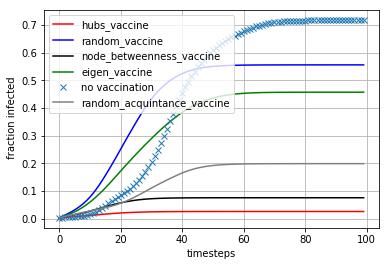

In [59]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs(G)
remove_random(G)
remove_node_btwn(G)
remove_eigen(G)
epidemic(G)
acquintance(G)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

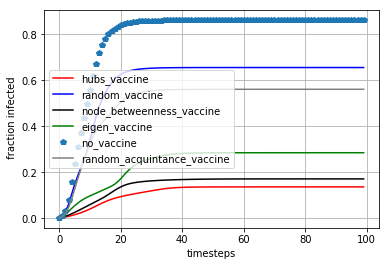

In [933]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs(D)
remove_random(D)
remove_node_btwn(D)
remove_eigen(D)
epidemic(D)
acquintance(D)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

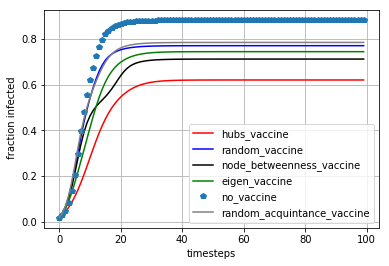

In [934]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs(Z)
remove_random(Z)
remove_node_btwn(Z)
remove_eigen(Z)
epidemic(Z)
acquintance(Z)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

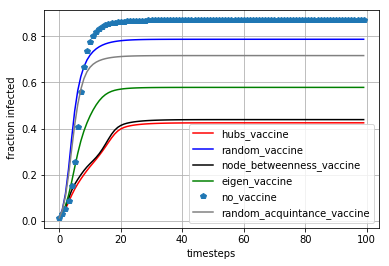

In [935]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs(F)
remove_random(F)
remove_node_btwn(F)
remove_eigen(F)
epidemic(F)
acquintance(F)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

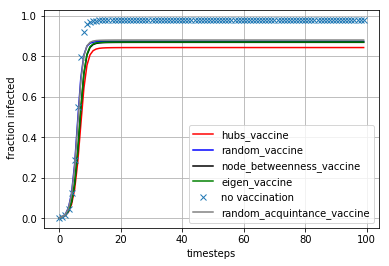

In [36]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs(ER)
remove_random(ER)
remove_node_btwn(ER)
remove_eigen(ER)
epidemic(ER)
acquintance(ER)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

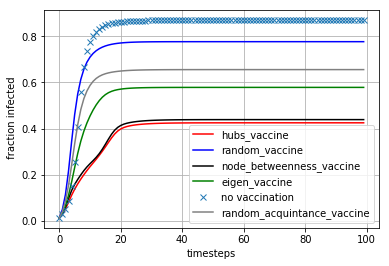

In [65]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs(F)
remove_random(F)
remove_node_btwn(F)
remove_eigen(F)
epidemic(F)
acquintance(F)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

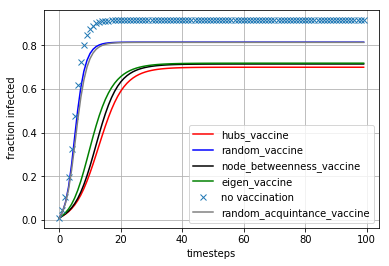

In [70]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs(BA)
remove_random(BA)
remove_node_btwn(BA)
remove_eigen(BA)
epidemic(BA)
acquintance(BA)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

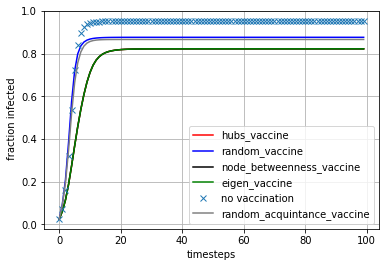

In [69]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs(rd)
remove_random(rd)
remove_node_btwn(rd)
remove_eigen(rd)
epidemic(rd)
acquintance(rd)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

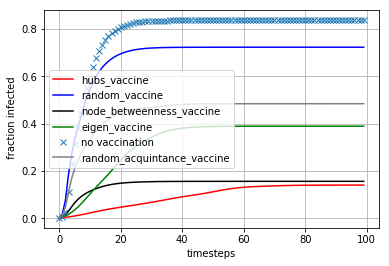

In [68]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs(air2)
remove_random(air2)
remove_node_btwn(air2)
remove_eigen(air2)
epidemic(air2)
acquintance(air2)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

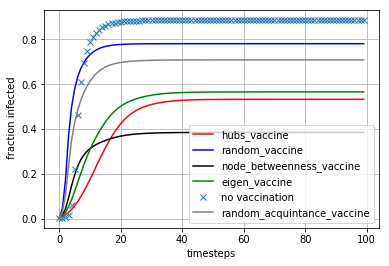

In [67]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs(air)
remove_random(air)
remove_node_btwn(air)
remove_eigen(air)
epidemic(air)
acquintance(air)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

# Line Graphs

In [37]:
L = nx.line_graph(G)
S = nx.line_graph(D)
X = nx.line_graph(Z)
Y= nx.line_graph(F)
R=nx.line_graph(ER)
U=nx.line_graph(BA)
Q=nx.line_graph(BA2)
P=nx.line_graph(ER2)

NameError: name 'BA' is not defined

# Social Distancing

In [174]:
def remove_hubs_edges(g): #removing hubs from line graph
    
    c=nx.line_graph(g)
    #sorting degrees
    deg=np.array(list(dict(c.degree()).values())).astype(float)
    deg_sort=sorted(deg, reverse=True)
    mx=deg_sort[:int(0.1*len(c.nodes()))]
    a=[]
    for nodes in c.nodes():
        if c.degree(nodes) in mx:
            a.append(nodes) 
    
    
    gnow=g.copy()
    gnow.remove_edges_from(a)

    A=nx.to_numpy_matrix(gnow)
    gnow=nx.from_numpy_matrix(A)
    component_subgraph_list = list(nx.connected_component_subgraphs(gnow))
    largest_component= max(component_subgraph_list,key=len)
                                   
    t=nx.degree_centrality(largest_component)
    sorted_tuples = sorted(t.items(), key=operator.itemgetter(1),reverse=True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    p=list(sorted_dict.keys()) 
    q=p[:5]
    s=[]
    for i in q:
        m=100
        gamma=.08
        beta=.14
        init = np.zeros(len(A))
        init[int(i)] = 1
        t,p1 = trial(A,gamma,beta,m,init)
        s.append(t)
        j=np.mean(s, axis=0)
    r=plt.plot(range(m),j/len(matrix(g)),'cyan',label=('max_connected_edges'))
#     plt.figure(figsize=(18,18))
   # plt.grid()
#     b=nx.draw_networkx(gnow)
#     plt.axis('off')
#     #plt.savefig("pth2.png")
#     plt.show()
    
    return r


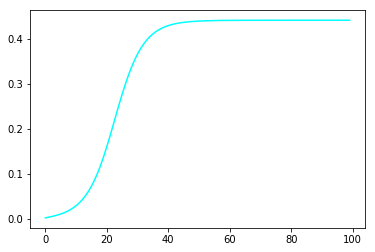

In [175]:
remove_hubs_edges(ER)

# Random

In [72]:
def rand_eg_removed(g):
    rand_eg=sample(list(g.edges()), int(0.1*len(g.edges())))
    gnow=g.copy()
    gnow.remove_edges_from(rand_eg) # removing random edges

    A=nx.to_numpy_matrix(gnow)
    gnow=nx.from_numpy_matrix(A) 
    #infecting the largest component
    component_subgraph_list = list(nx.connected_component_subgraphs(gnow))
    largest_component= max(component_subgraph_list,key=len)
    #infecting nodes with highest degrees and averaging                              
    t=nx.degree_centrality(largest_component)
    sorted_tuples = sorted(t.items(), key=operator.itemgetter(1),reverse=True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    p=list(sorted_dict.keys()) 
    q=p[:5]
    s=[]
    for i in q:
        m=100
        gamma=.08
        beta=.14
        init = np.zeros(len(A))
        init[int(i)] = 1
        t,p1 = trial(A,gamma,beta,m,init)
        s.append(t)
        c=np.mean(s, axis=0)
    r=plt.plot(range(m),c/len( matrix(g)),'p',label=('random_edges'))
#     plt.figure(figsize=(18,18))
#     b=nx.draw_networkx(gnow)
#     plt.axis('off')
#     #plt.savefig("pth2.png")
#     plt.show()
    return r

# betwn

In [180]:
def max_edge_btwn(g): #removing 10% edges with highest edge betweenness
    d=nx.edge_betweenness_centrality(g)
    sorted_tuples = sorted(d.items(), key=operator.itemgetter(1),reverse=True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    e=list(sorted_dict.keys()) 

    t=e[:int(0.88*len(g.edges()))] #10% edges with highest edge betweenness
    
    k=g.copy()
    k.remove_edges_from(t)
    A=nx.to_numpy_matrix(k)
    k=nx.from_numpy_matrix(A)
    
    component_subgraph_list = list(nx.connected_component_subgraphs(k)) #infecting largest component
    largest_component= max(component_subgraph_list,key=len)
                                   
    h=nx.degree_centrality(largest_component)
    sorted_tuples = sorted(h.items(), key=operator.itemgetter(1),reverse=True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    p=list(sorted_dict.keys()) 
    q=p[:5]
    s=[]
    for i in q:
        m=100
        gamma=.08
        beta=.14
        init = np.zeros(len(A))
        init[int(i)] = 1
        t,p1 = trial(A,gamma,beta,m,init)
        s.append(t)
        c=np.mean(s, axis=0)
    r=plt.plot(range(m),c/len( matrix(g)),'gold',label=('edge_betweenness'))
#      plt.figure(figsize=(18,18))

#     b=nx.draw_networkx(gnow)
#     plt.axis('off')
#     #plt.savefig("pth2.png")
#     plt.show()
    return r

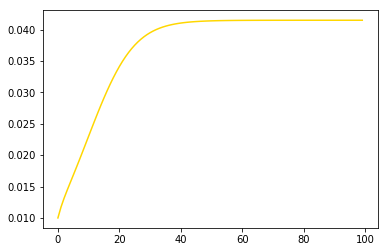

In [182]:
max_edge_btwn(BA)

In [74]:
def hubs(g): 
    """ten% nodes with the highest degree
    """
    deg=np.array(list(dict(g.degree()).values())).astype(float) 
    deg_sort=sorted(deg, reverse=True)#sorting degrees
    mx=deg_sort[:int(0.1*(len(g.nodes())))]
    a=[]
    for nodes in g.nodes:
        if g.degree(nodes) in mx:
            a.append(nodes)   
    return a

In [75]:
def highest_btwn_hubs(g): #edges with highest betweenness from hubs
    t=nx.edge_betweenness(g)
    s=[]
    u=[]
    for i in hubs(g): # edges of hubs
        r=list(g.edges([i]))
        s.append(r)
    def get_key(val):#betweenness of edges
        for key, value in t.items():
            if val == key or (key[1],key[0])==val:
                return key,value
    k=list(t.keys())
    my_btn = [[] for i in range(len(hubs(g)))] #hub_edges  and their edge_betweenness
    for i,j in enumerate(s):
        for k in j:
            y=get_key(k)
            my_btn[i].append(y)
    def maxi_edi(x): # returning edges with maximum betweenness
        maxi = max([i[1] for i in x])
        return [i for i in x if i[1]==maxi]
    for i in my_btn:
        u.append(maxi_edi(i))
    
    return u # LIST OF LISTS OF ALL HUB EDGES WITH THEIR MAXIMUM BETWEENNESS

In [76]:
def hub_edge_btwn(g): #unpacking list to get only the edges
    flat_list = []
    for sublist in highest_btwn_hubs(g):
        for item in sublist:
            flat_list.append(item[0])
    return(flat_list)

In [77]:
def max_hub_edge_btwn(g): #removing edges  with highest betweenness from hubs
    t=hub_edge_btwn(g)
    
    k=g.copy()
    k.remove_edges_from(t)
    A=nx.to_numpy_matrix(k)
    k=nx.from_numpy_matrix(A)
    
    component_subgraph_list = list(nx.connected_component_subgraphs(k))
    largest_component= max(component_subgraph_list,key=len)
                                   
    h=nx.degree_centrality(largest_component)
    sorted_tuples = sorted(h.items(), key=operator.itemgetter(1),reverse=True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    p=list(sorted_dict.keys()) 
    q=p[:5]
    s=[]
    for i in q:
        m=100
        gamma=.08
        beta=.14
        init = np.zeros(len(A))
        init[int(i)] = 1
        t,p1 = trial(A,gamma,beta,m,init)
        s.append(t)
        c=np.mean(s, axis=0)
    r=plt.plot(range(m),c/len( matrix(g)),'m',label=('edge_betweenness_hubs'))
#     plt.figure(figsize=(18,18))

#     b=nx.draw_networkx(k)
#     plt.axis('off')
#     #plt.savefig("pth2.png")
#     plt.show()
    return r

<Figure size 432x288 with 0 Axes>

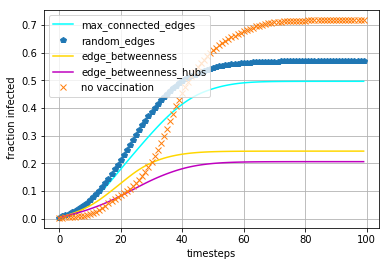

In [82]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs_edges(G)
rand_eg_removed(G)
max_edge_btwn(G)
max_hub_edge_btwn(G)
epidemic(G)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

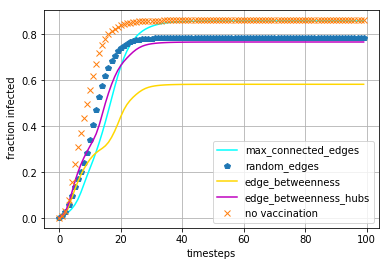

In [83]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs_edges(D)
rand_eg_removed(D)
max_edge_btwn(D)
max_hub_edge_btwn(D)
epidemic(D)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

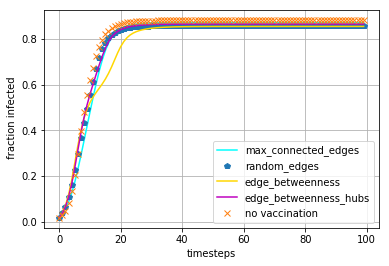

In [84]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs_edges(Z)
rand_eg_removed(Z)
max_edge_btwn(Z)
max_hub_edge_btwn(Z)
epidemic(Z)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

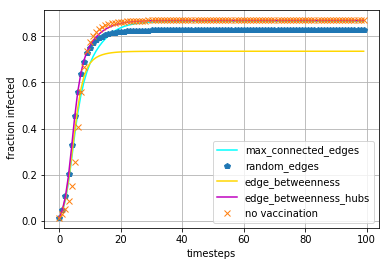

In [85]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs_edges(F)
rand_eg_removed(F)
max_edge_btwn(F)
max_hub_edge_btwn(F)
epidemic(F)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

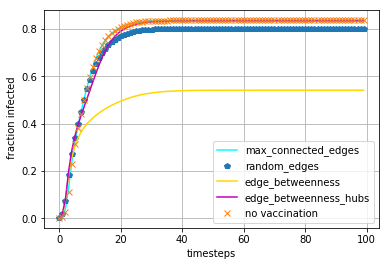

In [86]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs_edges(air2)
rand_eg_removed(air2)
max_edge_btwn(air2)
max_hub_edge_btwn(air2)
epidemic(air2)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

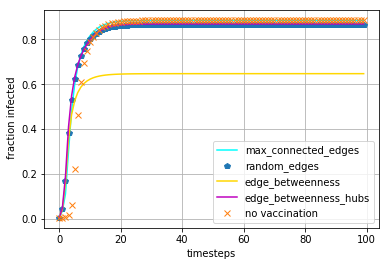

In [78]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs_edges(air)
rand_eg_removed(air)
max_edge_btwn(air)
max_hub_edge_btwn(air)
epidemic(air)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

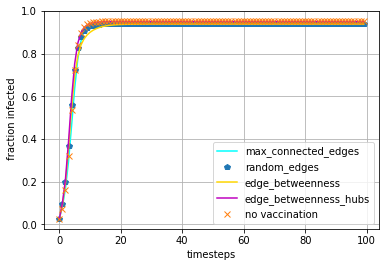

In [79]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs_edges(rd)
rand_eg_removed(rd)
max_edge_btwn(rd)
max_hub_edge_btwn(rd)
epidemic(rd)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

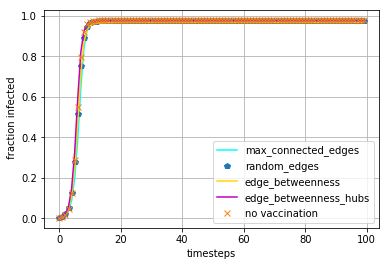

In [80]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs_edges(ER)
rand_eg_removed(ER)
max_edge_btwn(ER)
max_hub_edge_btwn(ER)
epidemic(ER)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

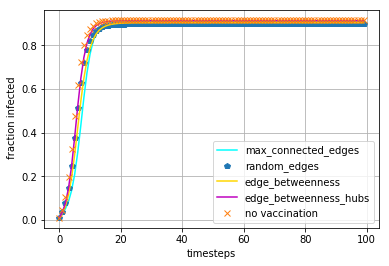

In [81]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs_edges(BA)
rand_eg_removed(BA)
max_edge_btwn(BA)
max_hub_edge_btwn(BA)
epidemic(BA)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

# Vaccination vs Social distancing

# Colorado Springs

<Figure size 432x288 with 0 Axes>

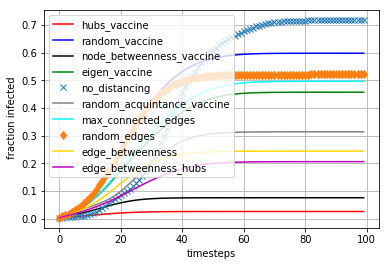

In [1855]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs(G)
remove_random(G)
remove_node_btwn(G)
remove_eigen(G)
epidemic(G)
acquintance(G)
remove_hubs_edges(G)
rand_eg_removed(G)
max_edge_btwn(G)
max_hub_edge_btwn(G)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

# Drugs

<Figure size 432x288 with 0 Axes>

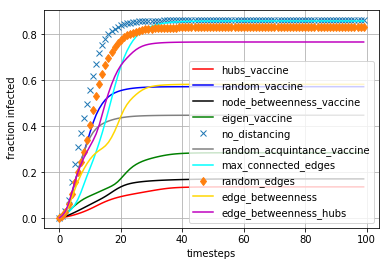

In [1856]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs(D)
remove_random(D)
remove_node_btwn(D)
remove_eigen(D)
epidemic(D)
acquintance(D)
remove_hubs_edges(D)
rand_eg_removed(D)
max_edge_btwn(D)
max_hub_edge_btwn(D)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

# Dolphin

<Figure size 432x288 with 0 Axes>

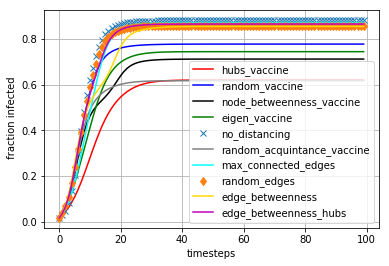

In [1857]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs(Z)
remove_random(Z)
remove_node_btwn(Z)
remove_eigen(Z)
epidemic(Z)
acquintance(Z)
remove_hubs_edges(Z)
rand_eg_removed(Z)
max_edge_btwn(Z)
max_hub_edge_btwn(Z)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

# Les Mis

<Figure size 432x288 with 0 Axes>

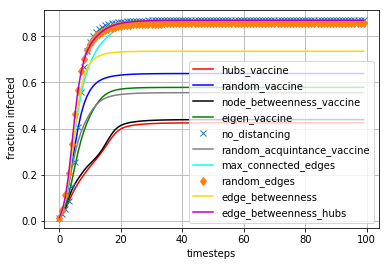

In [1858]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs(F)
remove_random(F)
remove_node_btwn(F)
remove_eigen(F)
epidemic(F)
acquintance(F)
remove_hubs_edges(F)
rand_eg_removed(F)
max_edge_btwn(F)
max_hub_edge_btwn(F)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

# Erdos Renyi

<Figure size 432x288 with 0 Axes>

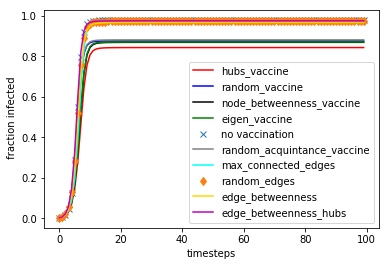

In [62]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs(ER)
remove_random(ER)
remove_node_btwn(ER)
remove_eigen(ER)
epidemic(ER)
acquintance(ER)
remove_hubs_edges(ER)
rand_eg_removed(ER)
max_edge_btwn(ER)
max_hub_edge_btwn(ER)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

# Barabasi Albert

<Figure size 432x288 with 0 Axes>

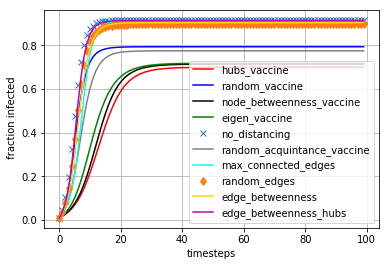

In [1861]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs(BA)
remove_random(BA)
remove_node_btwn(BA)
remove_eigen(BA)
epidemic(BA)
acquintance(BA)
remove_hubs_edges(BA)
rand_eg_removed(BA)
max_edge_btwn(BA)
max_hub_edge_btwn(BA)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

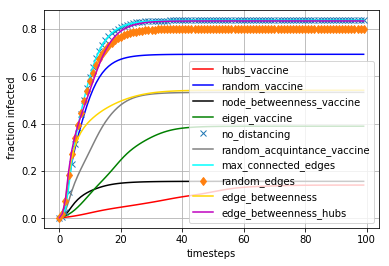

In [1862]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs(rd)
remove_random(rd)
remove_node_btwn(rd)
remove_eigen(rd)
epidemic(rd)
acquintance(rd)
remove_hubs_edges(rd)
rand_eg_removed(rd)
max_edge_btwn(rd)
max_hub_edge_btwn(rd)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

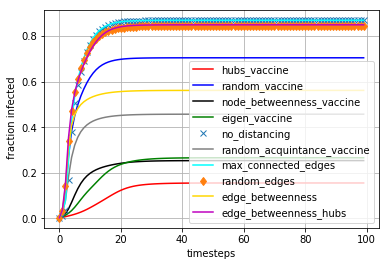

In [1863]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs(air2)
remove_random(air2)
remove_node_btwn(air2)
remove_eigen(air2)
epidemic(air2)
acquintance(air2)
remove_hubs_edges(air2)
rand_eg_removed(air2)
max_edge_btwn(air2)
max_hub_edge_btwn(air2)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

# Vaccination and Social Distancing

# Random vaccination and random social distancing

In [435]:
def vaccine_distancing_random(g):
    ran= sample(list(g.nodes()), int(0.1*len(g.nodes()))) 
    rand_eg=sample(list(g.edges()), int(0.1*len(g.nodes())))
    
    gnow=g.copy()
    gnow.remove_nodes_from(ran)
    gnow.remove_edges_from(rand_eg)
    A=nx.to_numpy_matrix(gnow)
    gnow=nx.from_numpy_matrix(A) 
    #infecting the largest component
    component_subgraph_list = list(nx.connected_component_subgraphs(gnow))
    largest_component= max(component_subgraph_list,key=len)
                                   
    t=nx.degree_centrality(largest_component)
    sorted_tuples = sorted(t.items(), key=operator.itemgetter(1),reverse=True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    p=list(sorted_dict.keys()) 
    q=p[:5]
    s=[]
    for i in q:
        m=100
        gamma=.08
        beta=.14
        init = np.zeros(len(A))
        init[int(i)] = 1
        t,p1 = trial(A,gamma,beta,m,init)
        s.append(t)
        c=np.mean(s, axis=0)
    r=plt.plot(range(m),c/len( matrix(g)),'b',label=('random_vaccine and distancing'))

    return r

# Acquaintance vaccination and random social distancing

In [1286]:
eigenvalue(G)

[2.507, 0.049, 1.773, 0.593, 0.038]

In [1287]:
eigenvalue(D)

[10.74, 1.493, 6.823, 4.441, 3.159]

In [78]:
eigenvalue(F)

[3.955, 2.177, 2.864, 3.977, 2.139]

In [ ]:
eigenvalue(Z)

In [79]:
eigenvalue(ER)

[3.212, 1.303, 2.569, 2.542, 1.32]

In [1291]:
eigenvalue(BA)

[5.519, 0.688, 5.197, 4.976, 3.943]

Network     &      Hubs     &   Random   &   Betweenness & Eigenvector & Acquaintance\\
Colorado Springs&  2.507   &    0.049&1.773&0.593   &     0.038\\
Drugs           &  10.74   &    1.493     &  6.823   &     4.441    &    3.159\\
Les Miserables  &  3.955   &    1.219     &  2.864   &     3.977    &    1.976\\
Dolphin         &  2.645   &    0.796&0.825   &     1.243    &    0.687\\
Erdos-Renyi&2.415   &    0.63      &  1.522    &    1.534    &    0.848\\
Barabasi-Albert &  5.519   &    0.688     &  5.197    &    4.976    &    3.943\\


In [169]:
a=[2.507, 0.049, 1.773, 0.593, 0.038]
b=[10.74, 1.493, 6.823, 4.441, 3.159]
w=[3.955, 1.219, 2.864, 3.977, 1.976]
e=[3.168, 1.254, 1.642, 1.252, 1.225]
r=[2.415, 0.63, 1.522, 1.534, 0.848]
t=[5.519, 0.688, 5.197, 4.976, 3.943]
x=np.array([a,b,w,e,r,t])
np.mean(x,axis=0)

array([4.71733333, 0.88883333, 3.3035    , 2.7955    , 1.86483333])

In [171]:
tb=[['Network','Hubs','Random','Betweenness','Eigenvector ','Acquaintance'
],['Colorado Springs',2.507, 0.049, 1.773, 0.593, 0.038],['Drugs', 10.74, 1.493, 6.823, 4.441, 3.159],['Les Miserables', 3.955, 1.219, 2.864, 3.977, 1.976],['Dolphin', 2.645, 0.796, 0.825, 1.243, 0.687],
['Erdos-Renyi', 2.415, 0.63, 1.522, 1.534, 0.848],['Barabasi-Albert', 5.519, 0.688, 5.197, 4.976, 3.943],['Average', 4.71733333, 0.88883333, 3.3035    , 2.7955    , 1.86483333]]
print(tabulate(tb))

----------------  ----------  ----------  -----------  -----------  ------------
Network           Hubs        Random      Betweenness  Eigenvector  Acquaintance
Colorado Springs  2.507       0.049       1.773        0.593        0.038
Drugs             10.74       1.493       6.823        4.441        3.159
Les Miserables    3.955       1.219       2.864        3.977        1.976
Dolphin           2.645       0.796       0.825        1.243        0.687
Erdos-Renyi       2.415       0.63        1.522        1.534        0.848
Barabasi-Albert   5.519       0.688       5.197        4.976        3.943
Average           4.71733333  0.88883333  3.3035       2.7955       1.86483333
----------------  ----------  ----------  -----------  -----------  ------------


In [235]:
def eigenvalue(g):
    x=[max(np.linalg.eigvals(matrix(g)))] # largest eigenvalue of adjacency matrix
    y=[max(np.linalg.eigvals(remove_hubs(g))),max(np.linalg.eigvals(remove_random(g))),max(np.linalg.eigvals(remove_node_btwn(g))),max(np.linalg.eigvals(remove_eigen(g))),max(np.linalg.eigvals(acquintance(g)))]
    h=[]
    for i in range(len(y)): #getting difference of largest eigenvalue after vaccination
        k=(x[0]-y[i])
        h.append(round(k.real,3))
    return h

In [1295]:
eigenvalue2(G)

[3.462, 0.366, 1.857, 0.609, 1.78]

In [1296]:
eigenvalue2(D)

[12.297, 3.775, 6.823, 4.441, 4.093]

In [1297]:
eigenvalue2(F)

[6.006, 4.348, 5.598, 4.861, 6.197]

In [1298]:
eigenvalue2(Z)

[3.168, 1.254, 1.642, 1.252, 1.225]

In [1299]:
eigenvalue2(ER)

[3.458, 1.012, 2.597, 2.363, 1.199]

In [1300]:
eigenvalue2(BA)

[6.557, 2.493, 6.468, 5.901, 2.806]

In [166]:
a=[3.462, 0.366, 1.857, 0.609, 1.78]
b=[12.297, 3.775, 6.823, 4.441, 4.093]
w=[6.006, 4.348, 5.598, 4.861, 6.197]
e=[3.168, 1.254, 1.642, 1.252, 1.225]
r=[3.458, 1.012, 2.597, 2.363, 1.199]
t=[6.557, 2.493, 6.468, 5.901, 2.806]
x=np.array([a,b,w,e,r,t])
np.mean(x,axis=0)

array([5.82466667, 2.208     , 4.16416667, 3.23783333, 2.88333333])

In [168]:
tb2=[['Network','Hubs','Random','Betweenness','Eigenvector ','Acquaintance'
],['Colorado Springs',3.462, 0.366, 1.857, 0.609, 1.78],['Drugs', 12.297, 3.775, 6.823, 4.441, 4.093],['Les Miserables', 6.006, 4.348, 5.598, 4.861, 6.197],['Dolphin', 3.168, 1.254, 1.642, 1.252, 1.225],
['Erdos-Renyi', 3.458, 1.012, 2.597, 2.363, 1.199],['Barabasi-Albert',6.557, 2.493, 6.468, 5.901, 2.806],['Average', 5.82466667, 2.208     , 4.16416667, 3.23783333, 2.88333333]]
print(tabulate(tb2))

----------------  ----------  ------  -----------  -----------  ------------
Network           Hubs        Random  Betweenness  Eigenvector  Acquaintance
Colorado Springs  3.462       0.366   1.857        0.609        1.78
Drugs             12.297      3.775   6.823        4.441        4.093
Dolphin           6.006       4.348   5.598        4.861        6.197
Les Miserables    3.168       1.254   1.642        1.252        1.225
Erdos-Renyi       3.458       1.012   2.597        2.363        1.199
Barabasi-Albert   6.557       2.493   6.468        5.901        2.806
Average           5.82466667  2.208   4.16416667   3.23783333   2.88333333
----------------  ----------  ------  -----------  -----------  ------------


In [236]:
def eigenvalue3(g):
    x=[max(np.linalg.eigvals(matrix(g)))]
    y=[max(np.linalg.eigvals(remove_hubs3(g))),max(np.linalg.eigvals(remove_random3(g))),max(np.linalg.eigvals(remove_node_btwn3(g))),max(np.linalg.eigvals(remove_eigen3(g)))]
    h=[]
    for i in range(len(y)):
        k=(x[0]-y[i])
        h.append(round(k.real,3))
    return h

In [1302]:
 eigenvalue3(G)

[4.877, 0.764, 3.877, 1.092, 1.805]

In [1303]:
 eigenvalue3(D)

[13.958, 5.732, 6.823, 4.441, 10.078]

In [1304]:
 eigenvalue3(F)


[7.006, 3.785, 6.709, 4.918, 3.632]

In [1305]:
 eigenvalue3(Z)

[3.302, 2.037, 2.988, 1.257, 1.832]

In [182]:
 eigenvalue3(ER)

[4.211, 1.542, 3.451, 2.99]

In [1308]:
 eigenvalue3(BA)

[7.672, 1.974, 6.914, 6.519, 3.98]

In [185]:
a=[4.877, 0.764, 3.877, 1.092, 1.805]
b=[13.958, 5.732, 6.823, 4.441, 10.078]
w=[7.006, 3.785, 6.709, 4.918, 3.632]
e=[3.302, 2.037, 2.988, 1.257, 1.832]
r=[4.211, 1.542, 3.451, 2.99,4]
t=[7.672, 1.974, 6.914, 6.519, 3.98]
x=np.array([a,b,w,e,r,t])
np.mean(x,axis=0)

array([6.83766667, 2.639     , 5.127     , 3.53616667, 4.22116667])

In [186]:
tb2=[['Network','Hubs','Random','Betweenness','Eigenvector ','Acquaintance'
],['Colorado Springs',4.877, 0.764, 3.877, 1.092, 1.805],['Drugs',13.958, 5.732, 6.823, 4.441, 10.078],['Les Miserables', 7.006, 3.785, 6.709, 4.918, 3.632],['Dolphin', 3.302, 2.037, 2.988, 1.257, 1.832],
['Erdos-Renyi', 4.211, 1.542, 3.451, 2.99,4],['Barabasi-Albert',7.672, 1.974, 6.914, 6.519, 3.98],['Average', 6.83766667, 2.639     , 5.127     , 3.53616667, 4.22116667]]
print(tabulate(tb2))

----------------  ----------  ------  -----------  -----------  ------------
Network           Hubs        Random  Betweenness  Eigenvector  Acquaintance
Colorado Springs  4.877       0.764   3.877        1.092        1.805
Drugs             13.958      5.732   6.823        4.441        10.078
Les Miserables    7.006       3.785   6.709        4.918        3.632
Dolphin           3.302       2.037   2.988        1.257        1.832
Erdos-Renyi       4.211       1.542   3.451        2.99         4
Barabasi-Albert   7.672       1.974   6.914        6.519        3.98
Average           6.83766667  2.639   5.127        3.53616667   4.22116667
----------------  ----------  ------  -----------  -----------  ------------


In [70]:
print(max(np.linalg.eigvals(remove_hubs_edges3(U))))
print(max(np.linalg.eigvals(rand_eg_removed3(BA))))
print(max(np.linalg.eigvals(max_edge_btwn3(BA))))
print(max(np.linalg.eigvals(max_hub_edge_btwn3(BA))))

(12.316519826019581+0j)
9.03469246709663
5.43086549972421
7.000307282446267


In [72]:
print(max(np.linalg.eigvals(matrix(G))))
print(max(np.linalg.eigvals(remove_hubs_edges3(L))))
print(max(np.linalg.eigvals(rand_eg_removed3(G))))
print(max(np.linalg.eigvals(max_edge_btwn3(G))))
print(max(np.linalg.eigvals(max_hub_edge_btwn3(G))))

(4.876695538598261+0j)
(6.999999999999995+0j)
(4.876695538598261+0j)
(4.048930667644493+0j)
(4.158754113090918+0j)


In [84]:
def eigenvalue_deg(g):
    x=[max(np.linalg.eigvals(matrix(g)))]
    y=[max(np.linalg.eigvals(remove_hubs_edges(g))),max(np.linalg.eigvals(rand_eg_removed(g))),max(np.linalg.eigvals(max_edge_btwn(g))),max(np.linalg.eigvals(max_hub_edge_btwn(g)))]
    h=[]
    for i in range(len(y)):
        k=(x[0]-y[i])
        h.append(round(k.real,3))
    return h

In [87]:
eigenvalue_deg(G)

[0.592, 0.041, 0.52, 0.269]

In [88]:
eigenvalue_deg(D)

[5.32, 1.663, 2.415, 0.773]

In [89]:
eigenvalue_deg(F)

[0.796, 0.66, 0.585, 0.555]

In [90]:
eigenvalue_deg(Z)

[1.457, 0.531, 0.152, 0.468]

In [91]:
eigenvalue_deg(ER)

[1.775, 1.172, 1.28, 0.33]

In [ ]:
eigenvalue_deg(ER2)

In [93]:
eigenvalue_deg(BA)

[2.617, 0.709, 1.51, 0.771]

In [461]:
eigenvalue_deg(BA2)

[-8.257, 1.048, 1.29, 0.176]

Network&Highly Connected Edges&Random&Betweenness&High-betweenness Hubs\\ \hline
Colorado Springs&0.592& 0.041& 0.52& 0.269\\ \hline
Drugs&5.32& 1.663& 2.415& 0.773\\ \hline
Les Miserables&0.796& 0.66& 0.585& 0.555\\ \hline
Dolphin&1.457& 0.531& 0.152&0.46\\ \hline
Erdos-Renyi&1.775& 1.172& 1.28& 0.33\\ \hline
Barabasi Albert&0.617& 0.709& 1.51& 0.771\\ \hline


In [519]:
tb4=[['Network','Line-graph Hubs','Random','Betweenness','High-betweenness Hubs'
],['Colorado Springs',-7.342, 0.241, 0.52, 0.269],['Drugs', -20.06, 1.513, 2.415, 0.773],['Les Miserables',-10.904, 1.12, 0.585, 0.555],['Dolphin', -3.458, 0.53, 0.152, 0.468],
['Erdos-Renyi',-3.243, 0.618, 0.766, 0.53],['Erdos-Renyi2',-3.095, 0.461, 0.759, 0.502 ],['Barabasi-Albert',-5.737, 0.846, 1.51, 0.771],['Barabasi 2',-8.257, 1.048, 1.29, 0.176 ],['Average',-7.762   ,  0.797125,  0.999625,  0.5055 ]]
print(tabulate(tb4))

----------------  ---------------  --------  -----------  ---------------------
Network           Line-graph Hubs  Random    Betweenness  High-betweenness Hubs
Colorado Springs  -7.342           0.241     0.52         0.269
Drugs             -20.06           1.513     2.415        0.773
Les Miserables    -10.904          1.12      0.585        0.555
Dolphin           -3.458           0.53      0.152        0.468
Erdos-Renyi       -3.243           0.618     0.766        0.53
Erdos-Renyi2      -3.095           0.461     0.759        0.502
Barabasi-Albert   -5.737           0.846     1.51         0.771
Barabasi 2        -8.257           1.048     1.29         0.176
Average           -7.762           0.797125  0.999625     0.5055
----------------  ---------------  --------  -----------  ---------------------


In [463]:
def eigenvalue_deg2(g):
    x=[max(np.linalg.eigvals(matrix(g)))]
    y=[max(np.linalg.eigvals(remove_hubs_edges2(nx.line_graph(g)))),max(np.linalg.eigvals(rand_eg_removed2(g))),max(np.linalg.eigvals(max_edge_btwn2(g))),max(np.linalg.eigvals(max_hub_edge_btwn2(g)))]
    h=[]
    for i in range(len(y)):
        k=(x[0]-y[i])
        h.append(round(k.real,3))
    return h

In [464]:
eigenvalue_deg2(G)

[-3.137, 0.56, 0.749, 0.602]

In [465]:
eigenvalue_deg2(D)

[-10.306, 3.531, 2.443, 1.298]

In [466]:
eigenvalue_deg2(F)

[-6.957, 1.438, 0.967, 1.241]

In [467]:
eigenvalue_deg2(Z)

[-2.132, 1.48, 0.52, 0.546]

In [468]:
eigenvalue_deg2(ER)

[-1.903, 1.111, 1.415, 0.891]

In [469]:
eigenvalue_deg2(ER2)

[-0.914, 0.844, 1.274, 0.713]

In [470]:
eigenvalue_deg2(BA)


[-5.23, 1.636, 2.713, 1.54]

In [471]:
eigenvalue_deg2(BA2)

[-4.583, 2.086, 2.956, 0.515]

In [553]:
a=[-3.137, 0.56, 0.749, 0.602]
b=[-10.306, 3.531, 2.443, 1.298]
w=[-6.957, 1.438, 0.967, 1.241]
e=[-2.132, 1.48, 0.52, 0.546]
r=[-1.903, 1.111, 1.415, 0.891]
t=[-0.914, 0.844, 1.274, 0.713]
c=[-5.23, 1.636, 2.713, 1.54]
d=[-4.583, 2.086, 2.956, 0.515]
x=np.array([a,b,w,e,r,t,c,d])
np.mean(x,axis=0)

array([-4.39525 ,  1.58575 ,  1.629625,  0.91825 ])

In [562]:
tb5=[['Network','Line-graph Hubs','Random','Betweenness','High-betweenness Hubs'
],['Colorado Springs',-3.137, 0.56, 0.749, 0.602],['Drugs', -10.306, 3.531, 2.443, 1.298],['Les Miserables',-6.957, 1.438, 0.967, 1.241],['Dolphin', -2.132, 1.48, 0.52, 0.546],
['Erdos-Renyi',-1.903, 1.111, 1.415, 0.891],['Erdos-Renyi2',-0.914, 0.844, 1.274, 0.713 ],['Barabasi-Albert',-5.23, 1.636, 2.713, 1.54],['Barabasi 2',-4.583, 2.086, 2.956, 0.515],['Average',-4.39525 ,  1.58575 ,  1.629625,  0.91825]]
print(tabulate(tb5))

----------------  ---------------  -------  -----------  ---------------------
Network           Line-graph Hubs  Random   Betweenness  High-betweenness Hubs
Colorado Springs  -3.137           0.56     0.749        0.602
Drugs             -10.306          3.531    2.443        1.298
Les Miserables    -6.957           1.438    0.967        1.241
Dolphin           -2.132           1.48     0.52         0.546
Erdos-Renyi       -1.903           1.111    1.415        0.891
Erdos-Renyi2      -0.914           0.844    1.274        0.713
Barabasi-Albert   -5.23            1.636    2.713        1.54
Barabasi 2        -4.583           2.086    2.956        0.515
Average           -4.39525         1.58575  1.629625     0.91825
----------------  ---------------  -------  -----------  ---------------------


In [ ]:
def eigenvalue_deg3(g):
    x=[max(np.linalg.eigvals(matrix(g)))]
    y=[max(np.linalg.eigvals(remove_hubs_edges3(nx.line_graph(g)))),max(np.linalg.eigvals(rand_eg_removed3(g))),max(np.linalg.eigvals(max_edge_btwn3(g))),max(np.linalg.eigvals(max_hub_edge_btwn3(g)))]
    h=[]
    for i in range(len(y)):
        k=(x[0]-y[i])
        h.append(round(k.real,3))
    return h

In [590]:
eigenvalue_deg3(G)

NameError: name 'eigenvalue_deg3' is not defined

In [ ]:
eigenvalue_deg3(D)

In [ ]:
eigenvalue_deg3(F)

In [ ]:
eigenvalue_deg3(Z)

In [ ]:
eigenvalue_deg3(ER)

In [ ]:
eigenvalue_deg3(ER2)

In [ ]:
eigenvalue_deg3(BA) 

In [ ]:
eigenvalue_deg3(BA2)

In [171]:
def thresholds(g,d,eign):
    #for i in range(5):
    m=200
    gamma=d
    beta=.06
    init = np.zeros(len(matrix(g)))
    init[:] = 1
    t,p1 = trial(matrix(g),gamma,beta,m,init)
    a=plt.loglog(range(m),t/len(matrix(g)),label=('s=',round((eign*beta)/d,3)))
    b=plt.legend()
    plt.grid()
    return a,b

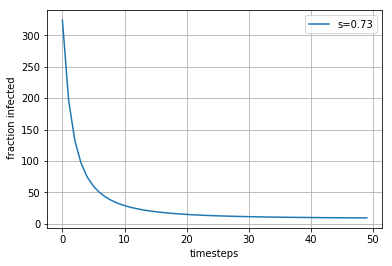

In [168]:
m=50
gamma=.5
beta=.12
init = np.zeros(len(matrix(G)))
init[:] = 1
t25,p1 = trial(matrix(G),gamma,beta,m,init)

fig1=plt.figure()
ax1=fig1.add_subplot(111)
# plt.plot(range(m),t23,label=('s=8.5'))
# plt.plot(range(m),t24,label=('s=0.12'))
plt.plot(range(m),t25,label=('s=0.73'))
plt.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

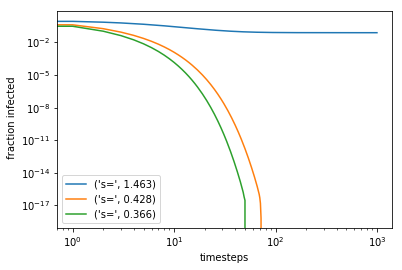

In [170]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
thresholds(G,0.2,round(max(np.linalg.eigvals(matrix(G))).real,3))
thresholds(G,0.6832,round(max(np.linalg.eigvals(matrix(G))).real,3))
thresholds(G,0.8,round(max(np.linalg.eigvals(matrix(G))).real,3))
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

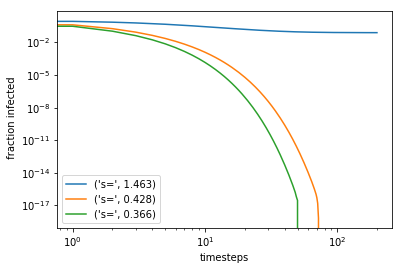

In [172]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
thresholds(G,0.2,round(max(np.linalg.eigvals(matrix(G))).real,3))
thresholds(G,0.6832,round(max(np.linalg.eigvals(matrix(G))).real,3))
thresholds(G,0.8,round(max(np.linalg.eigvals(matrix(G))).real,3))
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

In [1726]:
round(max(np.linalg.eigvals(matrix(remove_hubs(G)))).real,3)

2.37

TypeError: unhashable type: 'matrix'

<Figure size 432x288 with 0 Axes>

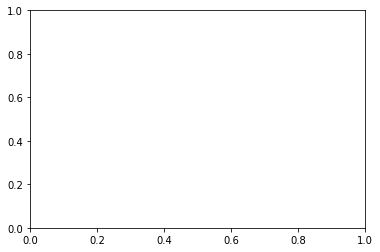

In [173]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
thresholds(remove_hubs(G),0.2,round(max(np.linalg.eigvals(matrix(remove_hubs(G)))).real,3))
thresholds(remove_hubs(G),0.6832,round(max(np.linalg.eigvals(matrix(remove_hubs(G)))).real,3))
thresholds(remove_hubs(G),0.8,round(max(np.linalg.eigvals(matrix(remove_hubs(G)))).real,3))
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

In [ ]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
thresholds(BA,0.2,max(np.linalg.eigvals(matrix(BA))))
thresholds(BA,0.537,max(np.linalg.eigvals(matrix(BA))))
thresholds(BA,0.8,max(np.linalg.eigvals(matrix(BA))))
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

In [ ]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
thresholds(remove_hubs(BA),0.2,round(max(np.linalg.eigvals(matrix(remove_hubs(BA)))).real,3))
thresholds(remove_hubs(BA),0.537,round(max(np.linalg.eigvals(matrix(remove_hubs(BA)))).real,3))
thresholds(remove_hubs(BA),0.8,round(max(np.linalg.eigvals(matrix(remove_hubs(BA)))).real,3))
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

# CLUSTERING

In [566]:
nx.average_clustering(G)

0.030146869230689894

In [9]:
nx.average_clustering(D)

0.549772486698583

In [568]:
nx.average_clustering(F)

0.5731367499320134

In [569]:
nx.average_clustering(Z)

0.2589582460550202

In [92]:
nx.average_clustering(ER)

0.024042652662244812

In [6]:
nx.average_clustering(ER2)

0.012012121212121208

In [7]:
nx.average_clustering(BA)

0.1365077949226556

In [8]:
nx.average_clustering(BA2)

0.1805322062565382

# AVERAGE DEGREE

In [596]:
def ave_deg(g):
    degrees=dict(g.degree())
    list_deg=list(degrees.values())
    av_k=np.mean(list_deg)
    return av_k

In [19]:
ave_deg(G)

2.1419753086419755

In [20]:
ave_deg(D)

6.532467532467533

In [21]:
ave_deg(F)

6.597402597402597

In [22]:
ave_deg(Z)

5.129032258064516

In [23]:
ave_deg(ER)

6.084

In [24]:
ave_deg(ER2)

4.988

In [25]:
ave_deg(BA)

5.82

In [26]:
ave_deg(BA2)

9.5

# EIGENVALUES

In [32]:
round(np.real(max(np.linalg.eigvals(matrix(G)))),2) #eigenvalues

4.88

In [33]:
round(np.real(max(np.linalg.eigvals(matrix(D)))),2)

18.01

In [34]:
round(np.real(max(np.linalg.eigvals(matrix(F)))),2)

12.01

In [35]:
round(np.real(max(np.linalg.eigvals(matrix(Z)))),2)

7.19

In [319]:
round(np.real(max(np.linalg.eigvals(matrix(ER)))),2)

13.27

In [37]:
round(np.real(max(np.linalg.eigvals(matrix(ER2)))),2)

6.07

In [693]:
round(np.real(max(np.linalg.eigvals(matrix(air2)))),2)

46.34

In [39]:
round(np.real(max(np.linalg.eigvals(matrix(BA2)))),2)

13.37

# SHORTEST PATH LENGTH

In [6]:
nx.average_shortest_path_length(D) #shortest path

5.283634251926935

In [7]:
nx.average_shortest_path_length(F)

2.6411483253588517

In [8]:
nx.average_shortest_path_length(Z)

3.3569539925965097

In [11]:
nx.average_shortest_path_length(BA)

2.571919191919192

# DEGREE ASSORTATIVITY

In [14]:
nx.degree_assortativity_coefficient(G)

-0.295396498301115

In [15]:
nx.degree_assortativity_coefficient(D)

-0.11746652517714112

In [16]:
nx.degree_assortativity_coefficient(F)

-0.16522513442236916

In [17]:
nx.degree_assortativity_coefficient(Z)

-0.04359402821531252

In [20]:
nx.degree_assortativity_coefficient(BA)

-0.14504790015205754

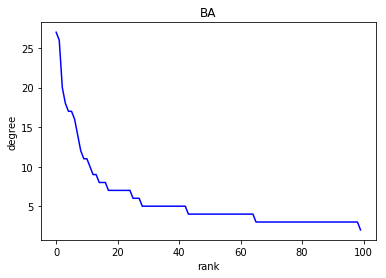

In [120]:
degree_sequence = sorted(dict(nx.degree(BA)).values(), reverse=True)
plt.plot(degree_sequence, 'b-')

# degree_sequence = sorted(dict(nx.degree(mG)).values(), reverse=True)
# plt.plot(degree_sequence, 'r-',label='er')
plt.title('BA')
plt.ylabel("degree")
plt.xlabel("rank")
plt.show()


https://stackoverflow.com/questions/41613077/how-to-compare-a-scale-free-and-random-network

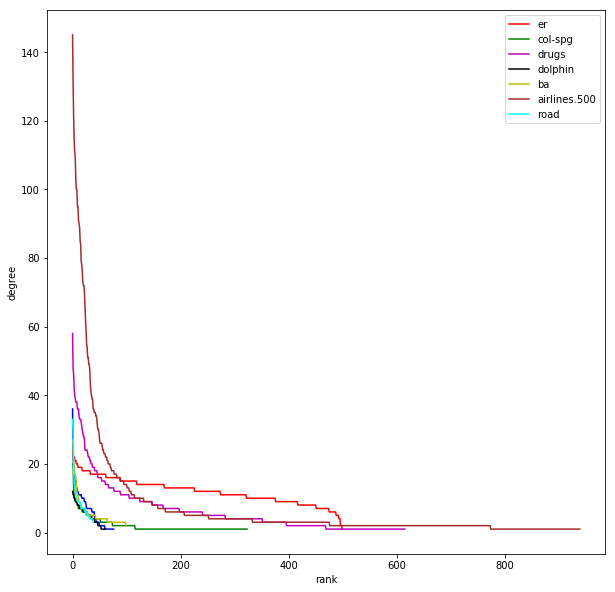

In [106]:
plt.figure(figsize=(10,10))
degree_sequence = sorted(dict(nx.degree(F)).values(), reverse=True)
plt.plot(degree_sequence, 'b-',)

degree_sequence = sorted(dict(nx.degree(ER)).values(), reverse=True)
plt.plot(degree_sequence, 'r-',label='er')

degree_sequence = sorted(dict(nx.degree(G)).values(), reverse=True)
plt.plot(degree_sequence, 'g',label='col-spg')

degree_sequence = sorted(dict(nx.degree(D)).values(), reverse=True)
plt.plot(degree_sequence, 'm',label='drugs')


degree_sequence = sorted(dict(nx.degree(Z)).values(), reverse=True)
plt.plot(degree_sequence, 'k',label='dolphin')

degree_sequence = sorted(dict(nx.degree(BA)).values(), reverse=True)
plt.plot(degree_sequence, 'y',label='ba')

degree_sequence = sorted(dict(nx.degree(air2)).values(), reverse=True)
plt.plot(degree_sequence, 'brown',label='airlines.500')

degree_sequence = sorted(dict(nx.degree(rd)).values(), reverse=True)
plt.plot(degree_sequence, 'cyan',label='road')

# degree_sequence = sorted(dict(nx.degree(mG)).values(), reverse=True)
# plt.plot(degree_sequence, 'gold',label='air.usa')

plt.ylabel("degree")
plt.xlabel("rank")
plt.legend()
plt.show()


# DENSITY d=2m/n(n-1)

In [696]:
nx.density(mG)

0.0386925344884068

In [700]:
nx.density(Z)

0.08408249603384453

In [695]:
nx.density(F)

0.08680792891319207

In [91]:
nx.density(ER) 

0.024160320641282564

In [1783]:
[len(list(dict(G.degree()).values())) if dict(G.degree()).values()==1]
list(dict(G.degree()).value())

SyntaxError: invalid syntax (<ipython-input-1783-174bcbff102a>, line 1)

208

In [570]:
dic={}
for nodes in partition.keys(): # getting comunitits
    if partition[nodes] in dic.keys():
        dic[partition[nodes]].append(nodes)
    else:
        dic[partition[nodes]]=[nodes]

In [571]:
sub={}
for community in dic.keys(): #seperating the communities
    sub[community]=D.subgraph(dic[community])

In [572]:
len_sub={community:len(sub[community]) for community in sub.keys()}

# MORE GRAPHS

In [107]:
mG=nx.read_weighted_edgelist('usa.air.txt')
len(mG.nodes())

332

In [636]:
len(mG.edges())

2126

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


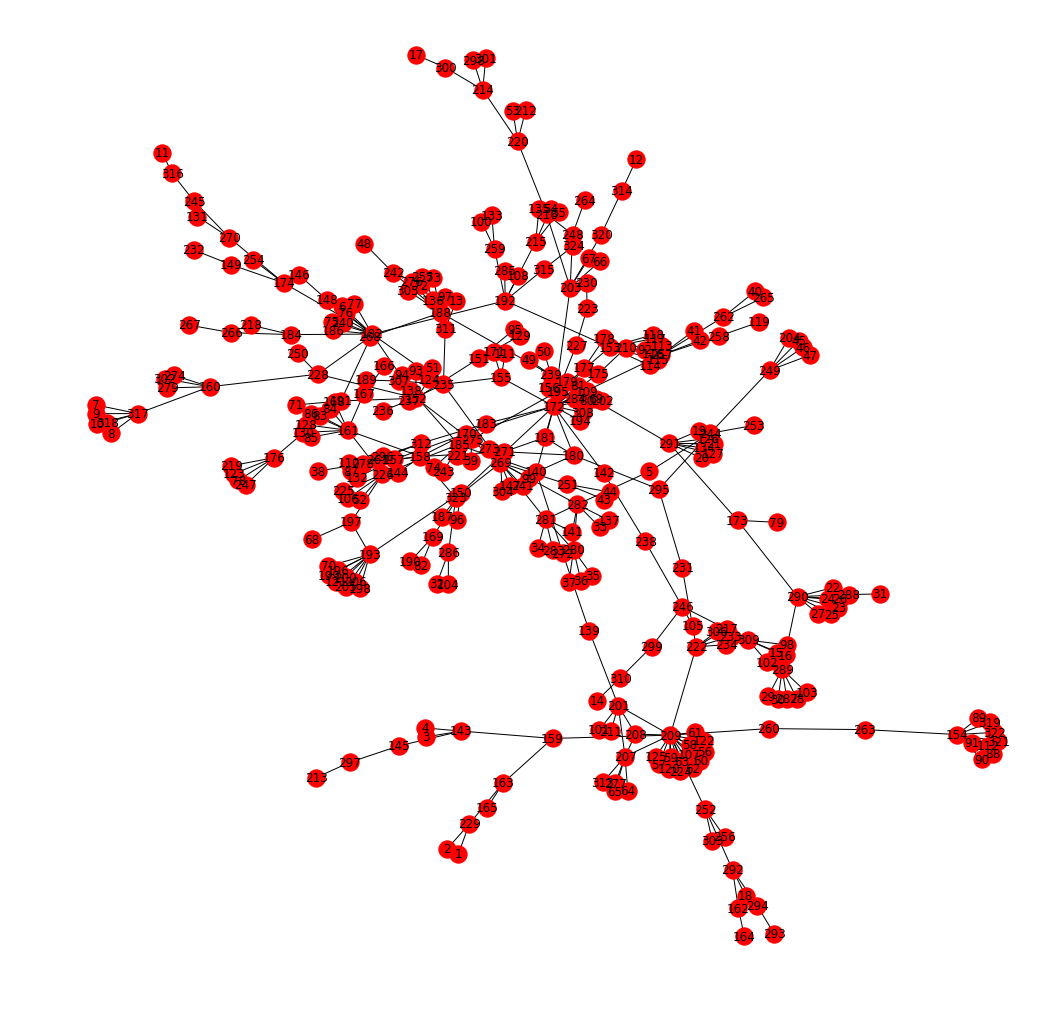

In [230]:
figure(mG)

In [616]:
print(nx.average_clustering(mG))
print(ave_deg(mG))
print(nx.average_shortest_path_length(mG))
print(nx.density(mG) )
print(round(np.real(max(np.linalg.eigvals(matrix(mG)))),2))

0.625217249162503
12.80722891566265
2.7381247042550867
0.0386925344884068
41.23


In [629]:
prim=nx.read_edgelist('primary.school.proximity.txt')

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


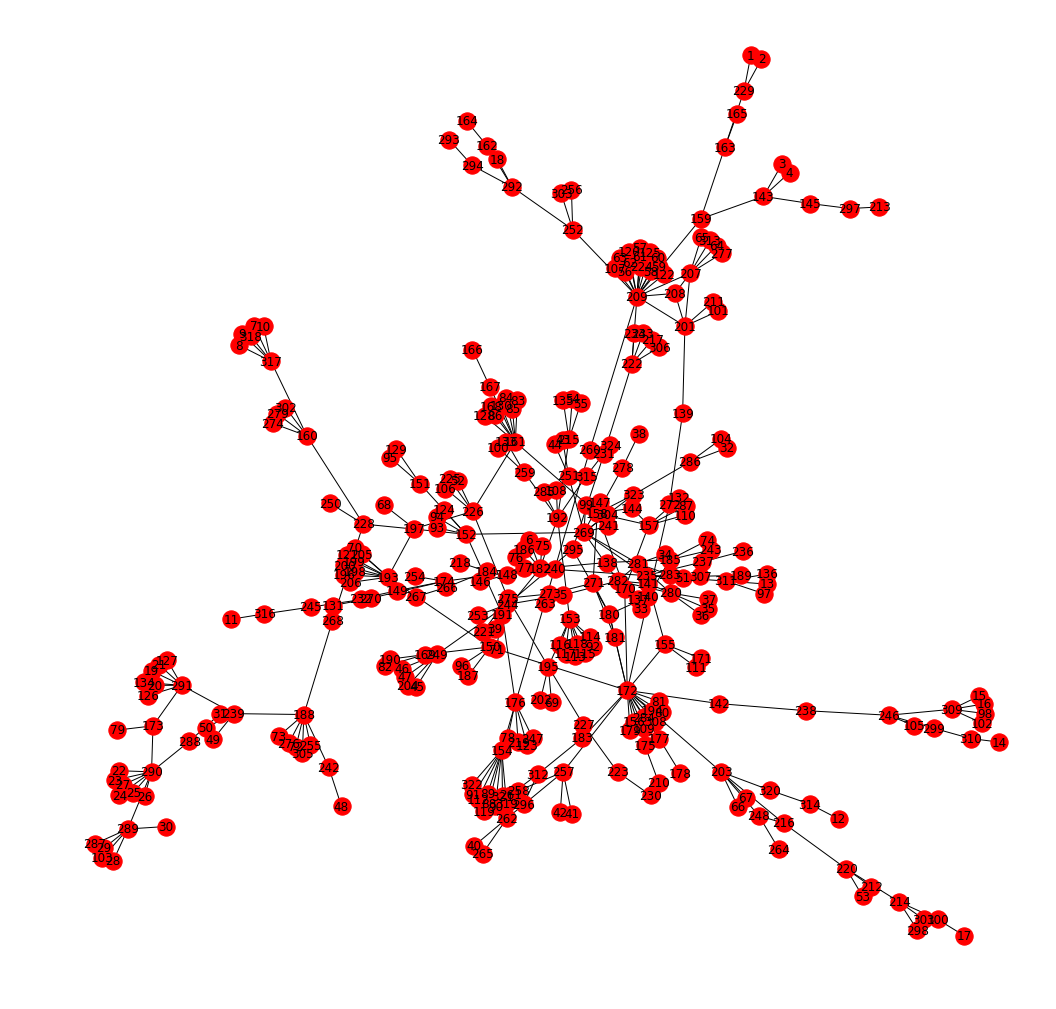

In [630]:
figure(prim)

In [637]:
prim.number_of_nodes()

242

In [631]:
print(nx.average_clustering(prim))
print(ave_deg(prim))
print(nx.average_shortest_path_length(prim))
print(nx.density(prim) )
print(round(np.real(max(np.linalg.eigvals(matrix(prim)))),2))

0.5255415410620272
68.73553719008264
1.7324508761702273
0.28520969788416034
80.25


In [197]:
rd.number_of_nodes()

39

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


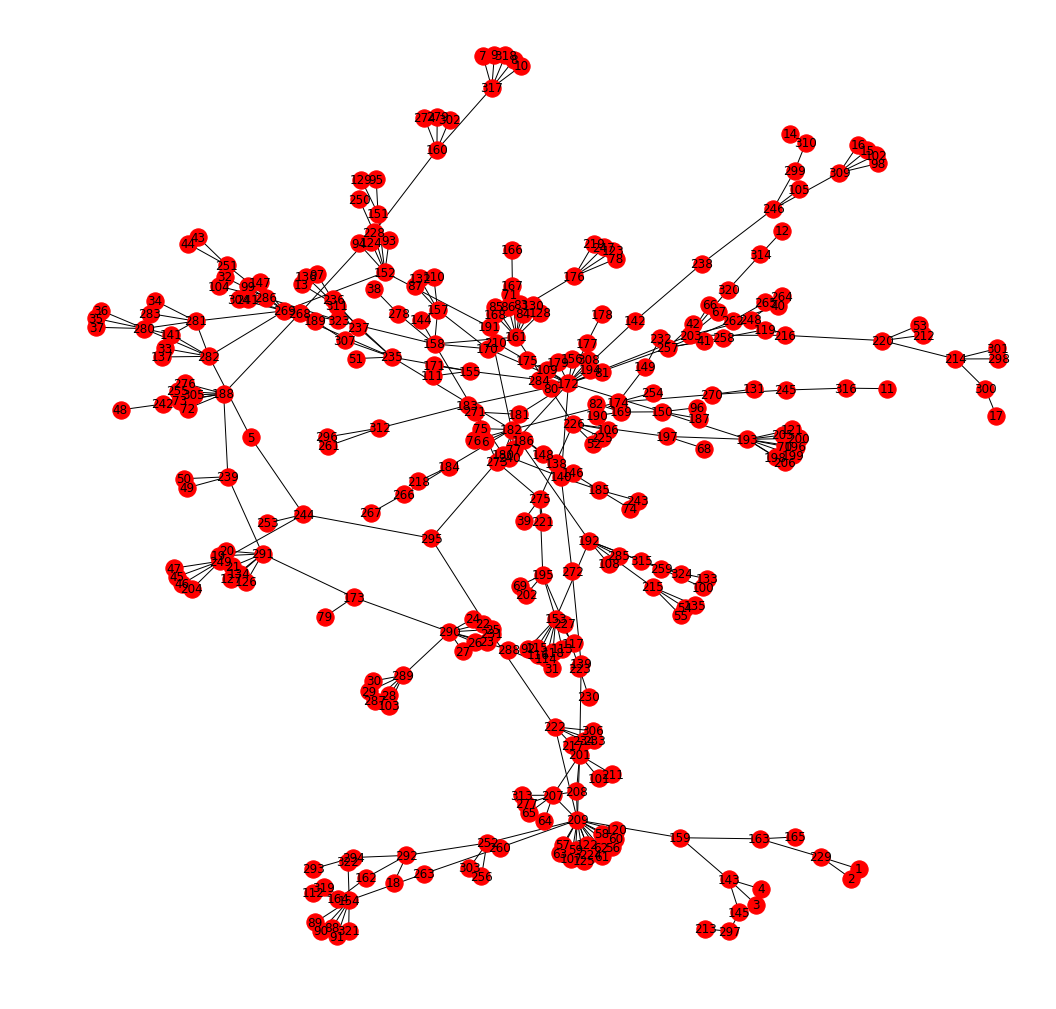

In [198]:
figure(rd)

In [187]:
print(nx.average_clustering(rd))
print(ave_deg(rd))
print(nx.average_shortest_path_length(rd))
print(nx.density(rd) )
print(round(np.real(max(np.linalg.eigvals(matrix(rd)))),2))

0.4447519510360827


NameError: name 'ave_deg' is not defined

In [111]:
air2.number_of_edges()

3446

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


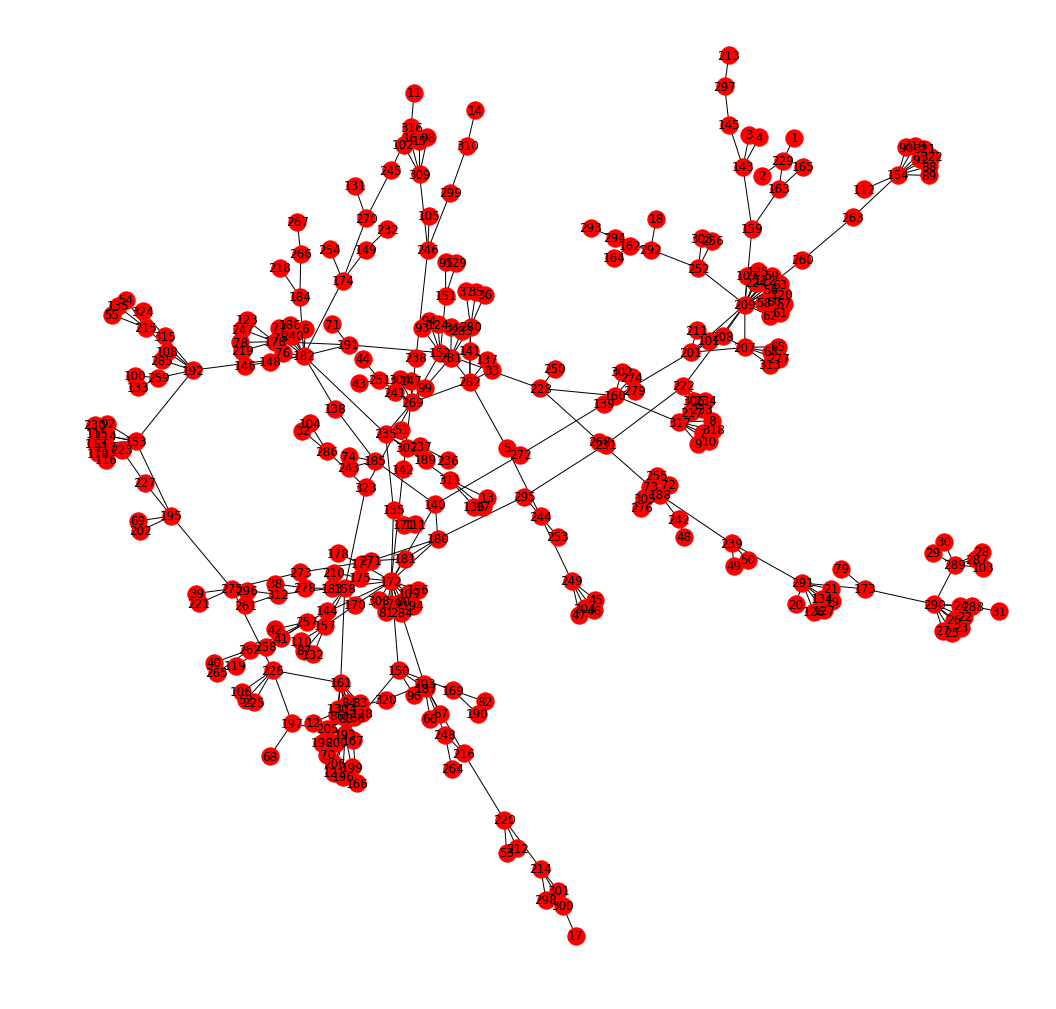

In [240]:
figure(air2)

In [600]:
print(nx.average_clustering(air2))
print(ave_deg(air2))
print(nx.average_shortest_path_length(air2))
print(nx.density(air2) )
print(round(np.real(max(np.linalg.eigvals(matrix(air2)))),2))

0.5986969878087571
11.501006036217303
3.0220597780229768
0.02318751216979295
46.34


In [592]:
airlines=nx.read_edgelist('largest.airlines.usa.txt')

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


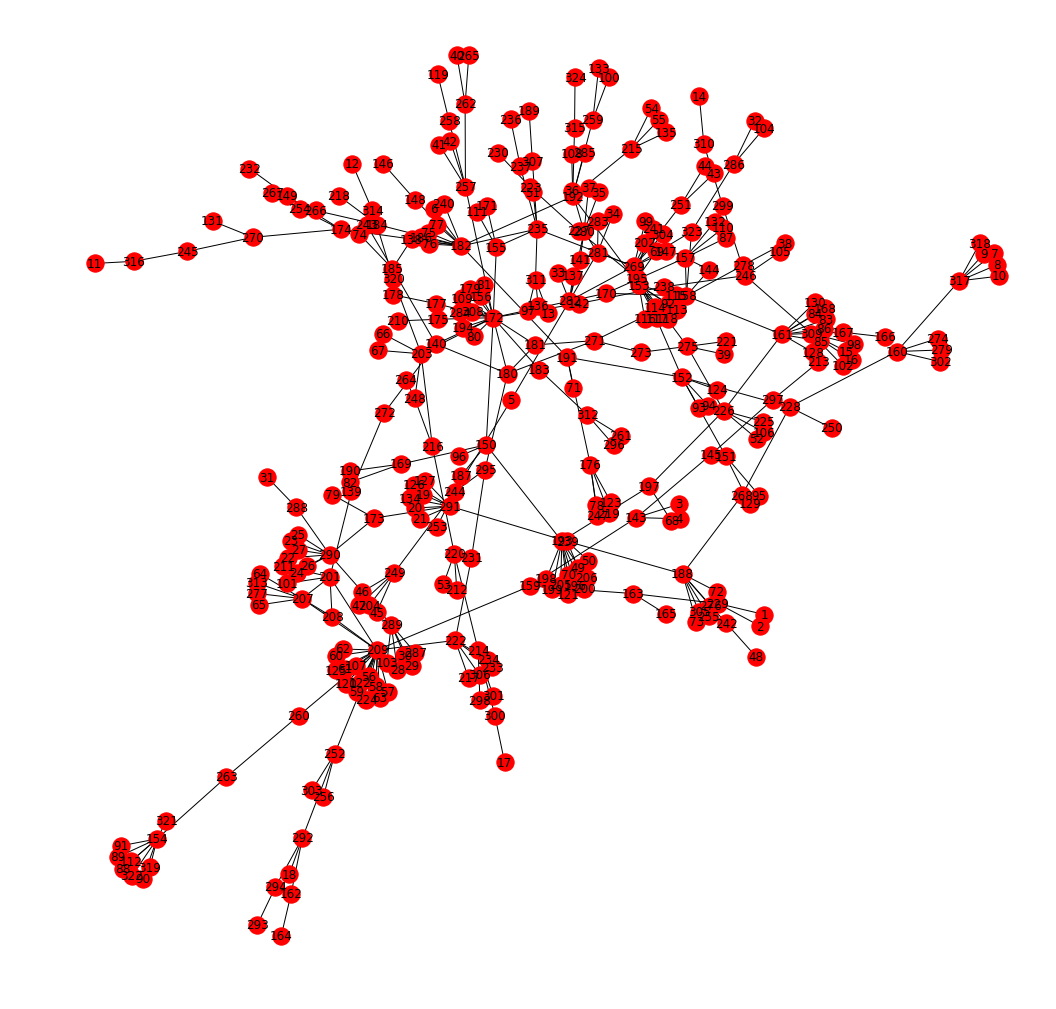

In [593]:
figure(airlines)


In [624]:
air2.number_of_nodes()

497

In [611]:
print(nx.average_clustering(airlines))
print(ave_deg(airlines))
print(nx.average_shortest_path_length(airlines))
print(nx.density(airlines) )
print(round(np.real(max(np.linalg.eigvals(matrix(airlines)))),2))

0.5986969878087571
11.501006036217303
3.0220597780229768
0.02318751216979295
46.34


<Figure size 432x288 with 0 Axes>

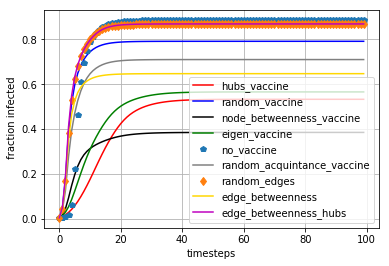

In [309]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs(mG)
remove_random(mG)
remove_node_btwn(mG)
remove_eigen(mG)
epidemic(mG)
acquintance(mG)
remove_hubs_edges(mG)
rand_eg_removed(mG)
max_edge_btwn(mG)
max_hub_edge_btwn(mG)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

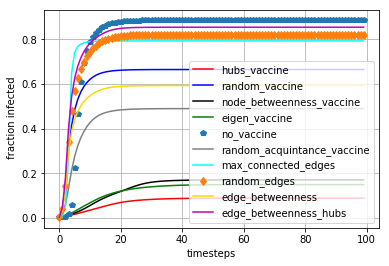

In [642]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs2(mG)
remove_random2(mG)
remove_node_btwn2(mG)
remove_eigen2(mG)
epidemic(mG)
acquintance2(mG)
remove_hubs_edges2(nx.line_graph(mG))
rand_eg_removed2(mG)
max_edge_btwn2(mG)
max_hub_edge_btwn2(mG)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

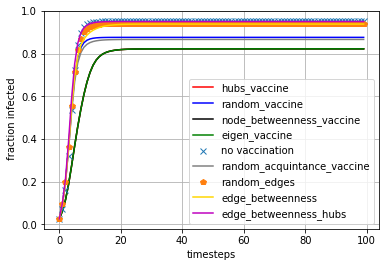

In [87]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs(rd)
remove_random(rd)
remove_node_btwn(rd)
remove_eigen(rd)
epidemic(rd)
acquintance(rd)
#remove_hubs_edges(Q)
rand_eg_removed(rd)
max_edge_btwn(rd)
max_hub_edge_btwn(rd)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

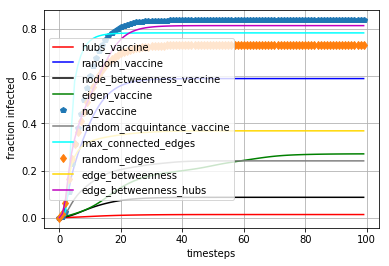

In [643]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs2(rd)
remove_random2(rd)
remove_node_btwn2(rd)
remove_eigen2(rd)
epidemic(rd)
acquintance2(rd)
remove_hubs_edges2(nx.line_graph(rd))
rand_eg_removed2(rd)
max_edge_btwn2(rd)
max_hub_edge_btwn2(rd)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

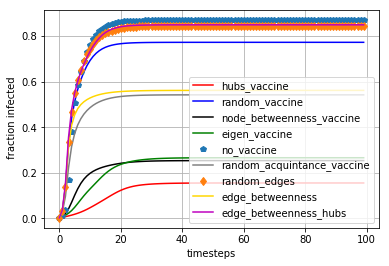

In [625]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs(air2)
remove_random(air2)
remove_node_btwn(air2)
remove_eigen(air2)
epidemic(air2)
acquintance(air2)
#remove_hubs_edges(Q)
rand_eg_removed(air2)
max_edge_btwn(air2)
max_hub_edge_btwn(air2)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

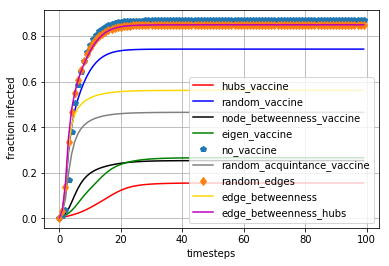

In [626]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs(airlines)
remove_random(airlines)
remove_node_btwn(airlines)
remove_eigen(airlines)
epidemic(airlines)
acquintance(airlines)
#remove_hubs_edges(Q)
rand_eg_removed(airlines)
max_edge_btwn(airlines)
max_hub_edge_btwn(airlines)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

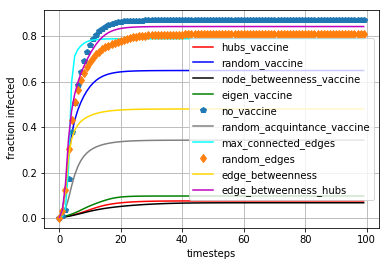

In [645]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
remove_hubs2(airlines)
remove_random2(airlines)
remove_node_btwn2(airlines)
remove_eigen2(airlines)
epidemic(airlines)
acquintance2(airlines)
remove_hubs_edges2(nx.line_graph(airlines))
rand_eg_removed2(airlines)
max_edge_btwn2(airlines)
max_hub_edge_btwn2(airlines)
ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

In [190]:
my_communities(Z)


{0: 12, 2: 15, 14: 23, 4: 24, 7: 20, 12: 9, 10: 17, 8: 13, 9: 12, 11: 9, 18: 20, 13: 15, 15: 9, 5: 20, 17: 8, 19: 26, 1: 23, 16: 15, 3: 23, 6: 11}
26
{0: 4, 1: 8, 2: 6, 3: 5, 4: 3}
8
{0: 4, 1: 8, 2: 6, 3: 5, 4: 3}
8
{0: 4, 1: 8, 2: 6, 3: 5, 4: 3}
8
{0: 4, 1: 8, 2: 6, 3: 5, 4: 3}
8


([<matplotlib.lines.Line2D at 0x7f8fbc103eb8>],
 <matplotlib.legend.Legend at 0x7f8fbc1031d0>)

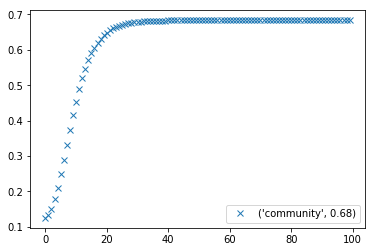

In [1174]:
epidemicom(my_communities(G))

In [210]:
def epidemic(g):
    #for i in range(5):
    m=100
    gamma=.08
    beta=.14
    init = np.zeros(len(matrix(g)))
    init[0] = 1
    t,p1 = trial(matrix(g),gamma,beta,m,init)
    a=plt.plot(range(m),t/len(matrix(G)),'x',label=(round(max(t/len(matrix(G))),2)))
    b=plt.legend()
    plt.xlabel('timesteps')
    plt.ylabel('fraction of infectives')
    return a,b

([<matplotlib.lines.Line2D at 0x7fd29dd254e0>],
 <matplotlib.legend.Legend at 0x7fd29dd25940>)

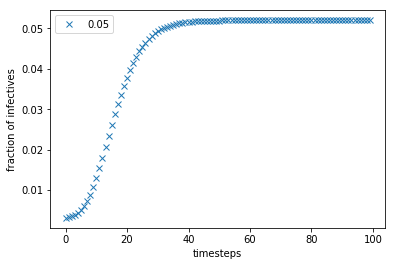

In [211]:
epidemic(my_communities(G))

In [212]:
def epidemic(g):
    #for i in range(5):
    m=100
    gamma=.08
    beta=.14
    init = np.zeros(len(matrix(g)))
    init[0] = 1
    t,p1 = trial(matrix(g),gamma,beta,m,init)
    a=plt.plot(range(m),t/len(matrix(D)),'x',label=(round(max(t/len(matrix(D))),2)))
    b=plt.legend()
    plt.xlabel('timesteps')
    plt.ylabel('fraction of infectives')
    
    return a,b

([<matplotlib.lines.Line2D at 0x7fd29e049eb8>],
 <matplotlib.legend.Legend at 0x7fd29e049828>)

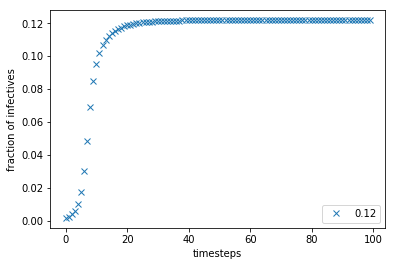

In [213]:
epidemic(my_communities(D))

In [259]:
def epidemic(g):
    #for i in range(5):
    m=100
    gamma=.08
    beta=.14
    init = np.zeros(len(matrix(g)))
    init[0] = 1
    t,p1 = trial(matrix(g),gamma,beta,m,init)
    a=plt.plot(range(m),t/len(matrix(F)),'x',label=(round(max(t/len(matrix(F))),2)))
    b=plt.legend() 
    plt.xlabel('timesteps')
    plt.ylabel('fraction of infectives',)
    
    return a,b

([<matplotlib.lines.Line2D at 0x7fee16b6ad68>],
 <matplotlib.legend.Legend at 0x7fee16c49b70>)

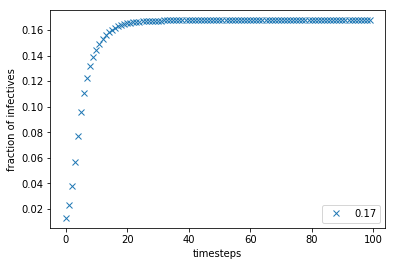

In [260]:
epidemic(my_communities(F))

In [197]:
def epidemic(g):
    #for i in range(5):
    m=100
    gamma=.08
    beta=.14
    init = np.zeros(len(matrix(g)))
    init[0] = 1
    t,p1 = trial(matrix(g),gamma,beta,m,init)
    a=plt.plot(range(m),t/len(matrix(ER)),'x',label=(round(max(t/len(matrix(ER))),2)))
    b=plt.legend()
    
    plt.xlabel('timesteps')
    plt.ylabel('fraction of infectives')
    return a,b

([<matplotlib.lines.Line2D at 0x7fee17e2b780>],
 <matplotlib.legend.Legend at 0x7fee1777f080>)

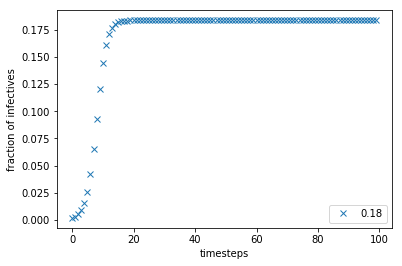

In [198]:
epidemic(my_communities(ER))

In [255]:
def epidemic(g):
    #for i in range(5):
    m=100
    gamma=.08
    beta=.14
    init = np.zeros(len(matrix(g)))
    init[0] = 1
    t,p1 = trial(matrix(g),gamma,beta,m,init)
    a=plt.plot(range(m),t/len(matrix(air2)),'x',label=(round(max(t/len(matrix(air2))),2)))
    b=plt.legend() 
    plt.xlabel('timesteps')
    plt.ylabel('fraction of infectives')
    
    return a,b

([<matplotlib.lines.Line2D at 0x7fee16f1c320>],
 <matplotlib.legend.Legend at 0x7fee16e32780>)

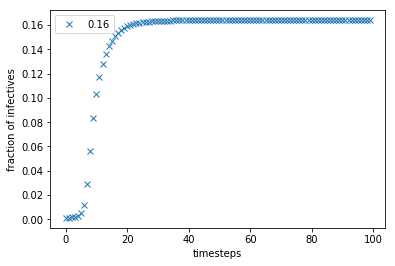

In [256]:
epidemic(my_communities(air2))

In [250]:
def epidemic(g):
    #for i in range(5):
    m=100
    gamma=.08
    beta=.14
    init = np.zeros(len(matrix(g)))
    init[0] = 1
    t,p1 = trial(matrix(g),gamma,beta,m,init)
    a=plt.plot(range(m),t/len(matrix(BA)),'x',label=(round(max(t/len(matrix(BA))),2)))
    b=plt.legend() 
    plt.xlabel('timesteps')
    plt.ylabel('fraction of infectives')
    return a,b

([<matplotlib.lines.Line2D at 0x7fee16ea1f98>],
 <matplotlib.legend.Legend at 0x7fee16ef44a8>)

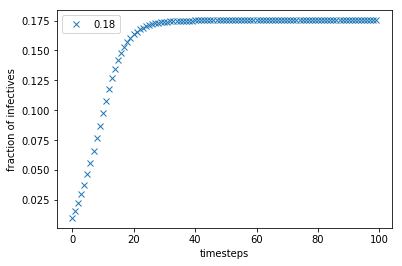

In [252]:
epidemic(my_communities(BA))

In [228]:
epidemic(my_communities(BA2))

NameError: name 'BA2' is not defined

In [234]:
def epidemic(g):
    #for i in range(5):
    m=100
    gamma=.08
    beta=.14
    init = np.zeros(len(matrix(g)))
    init[0] = 1
    t,p1 = trial(matrix(g),gamma,beta,m,init)
    a=plt.plot(range(m),t/len(matrix(rd)),'x',label=(round(max(t/len(matrix(rd))),2)))
    b=plt.legend() 
    plt.xlabel('timesteps')
    plt.ylabel('fraction of infectives')
    return a,b

([<matplotlib.lines.Line2D at 0x7fee171c9198>],
 <matplotlib.legend.Legend at 0x7fee17211390>)

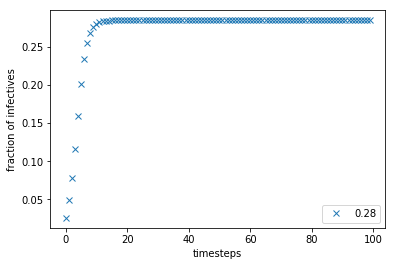

In [239]:
epidemic(my_communities(rd))

In [242]:
def epidemic(g):
    #for i in range(5):
    m=100
    gamma=.08
    beta=.14
    init = np.zeros(len(matrix(g)))
    init[0] = 1
    t,p1 = trial(matrix(g),gamma,beta,m,init)
    a=plt.plot(range(m),t/len(matrix(Z)),'x',label=(round(max(t/len(matrix(Z))),2)))
    b=plt.legend() 
    plt.xlabel('timesteps')
    plt.ylabel('fraction of infectives')
    return a,b

([<matplotlib.lines.Line2D at 0x7fee16fff400>],
 <matplotlib.legend.Legend at 0x7fee16fc7668>)

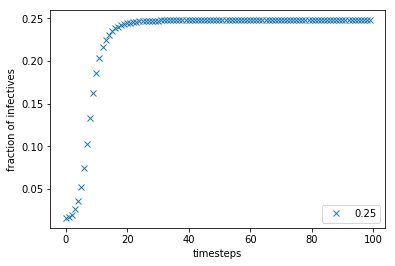

In [247]:
epidemic(my_communities(Z))

 # community_louvain

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


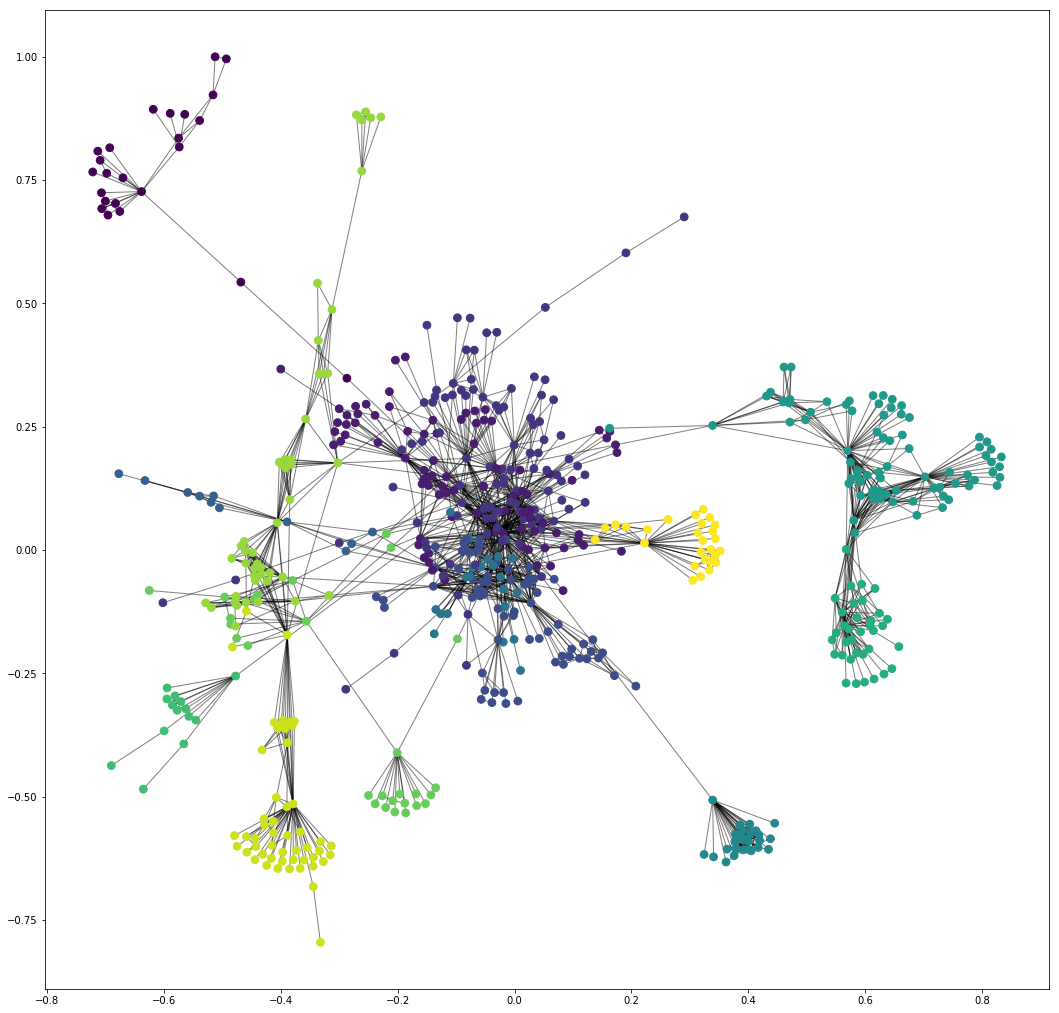

In [564]:
#partition = community_louvain.best_partition(D)

# compute the best partition
partition = community_louvain.best_partition(D)

# draw the graph
pos = nx.spring_layout(D)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)

plt.figure(figsize=(18,18))
nx.draw_networkx_nodes(D, pos, partition.keys(), node_size=60,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(D, pos, alpha=0.5)
plt.show()

In [2082]:
print(community_louvain.modularity(partition,Z))

KeyError: 'Beak'

In [2086]:
 community_louvain.best_partition?

In [185]:
def my_partition(g): #partition networks
    partition = community_louvain.best_partition(g)

# draw the graph
    pos = nx.spring_layout(g)
    # color the nodes according to their partition
    cmap = cm.get_cmap('viridis', max(partition.values()) + 1)

    plt.figure(figsize=(18,18))
    nx.draw_networkx_nodes(g, pos, partition.keys(), node_size=60,
                           cmap=cmap, node_color=list(partition.values()))
    a=nx.draw_networkx_edges(g, pos, alpha=0.5)
    plt.show()
    return a, community_louvain.modularity(partition,g)

In [186]:
partition2 = community_louvain.best_partition(G)
community_louvain.modularity(partition2,G)

0.8612229982808595

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


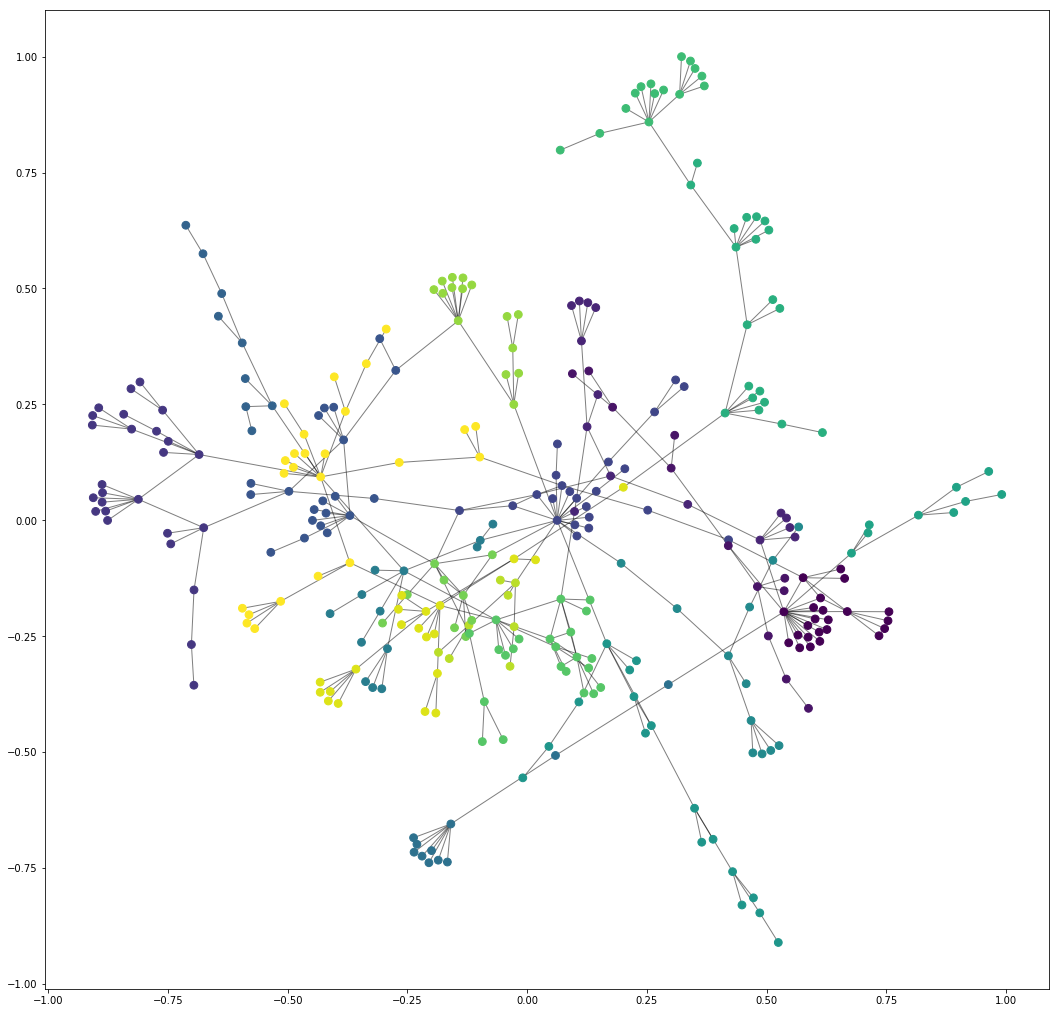

(<matplotlib.collections.LineCollection at 0x7f8fb56d5b00>, 0.8609198647941598)

In [2084]:
my_partition(G)

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


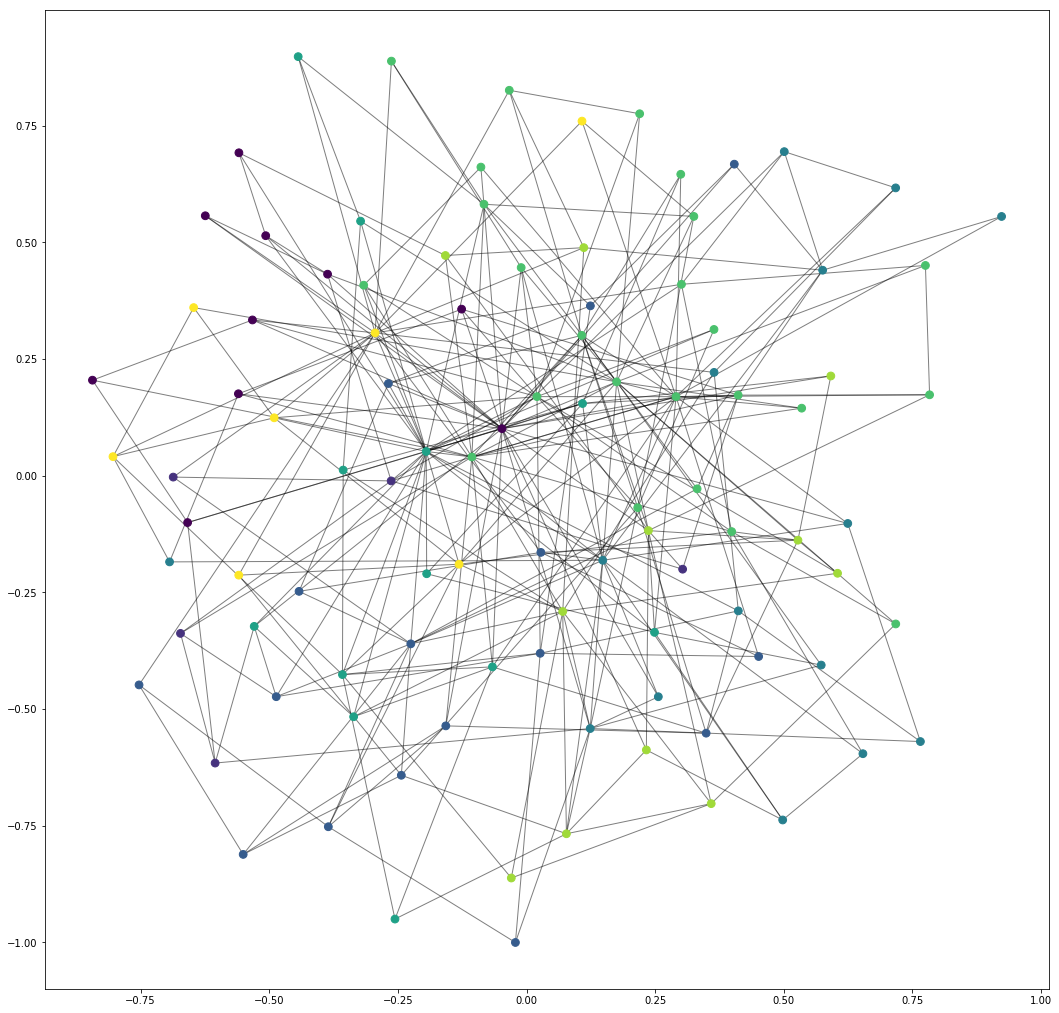

(<matplotlib.collections.LineCollection at 0x7fee16ddfcf8>, 0.3364863428632161)

In [348]:
my_partition(BA)

In [991]:
plt.figure(figsize=(12,12))
for community in sub.keys():
    if len_sub.values()==max(len_sub): # getting the largest community
        nx.draw_networkx(sub[community])
        break

<Figure size 864x864 with 0 Axes>

99


/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


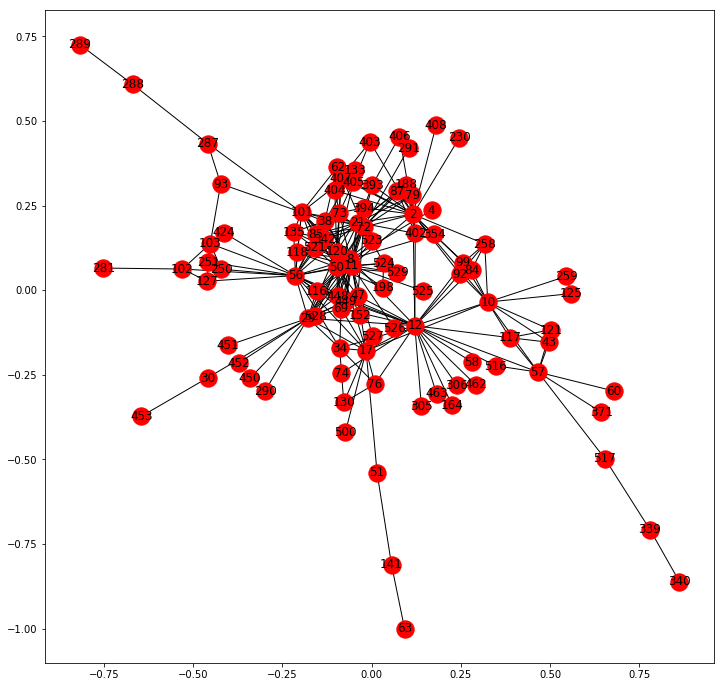

In [1166]:
plt.figure(figsize=(12,12))
for community in sub.keys():
    if len_sub[community]==max(len_sub.values()):
        print(len(sub[community]))
        # getting the largest community
        nx.draw_networkx(sub[community])
        break

#for index,community in enumerate(dic.keys()): All communities
    #plt.subplot(len(sub),1,index+1)
    #nx.draw_networkx(sub[community])


/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


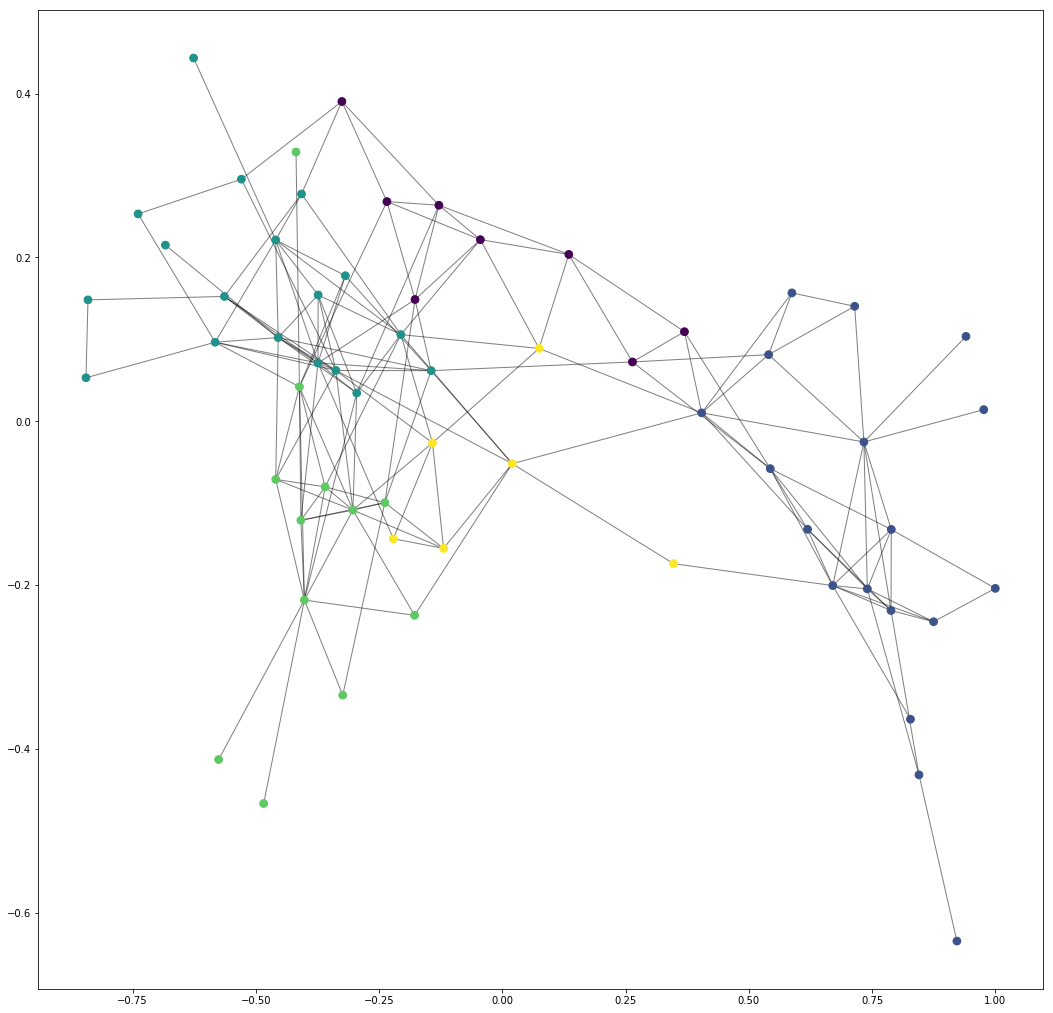

(<matplotlib.collections.LineCollection at 0x7f8fb488fb70>, 0.5188283691309679)

In [2104]:
my_partition(Z)

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


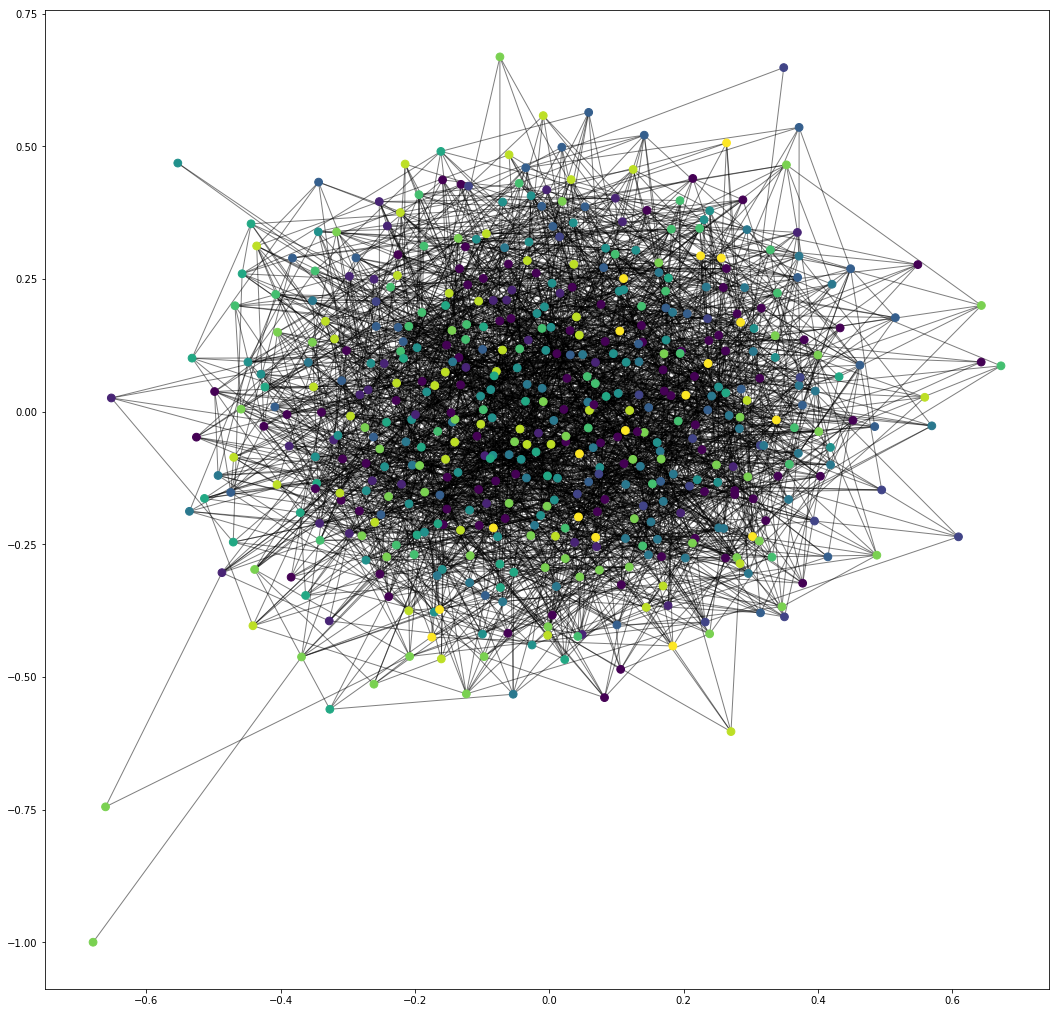

(<matplotlib.collections.LineCollection at 0x7fee1de17908>,
 0.25195102571542927)

In [187]:
my_partition(ER)

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


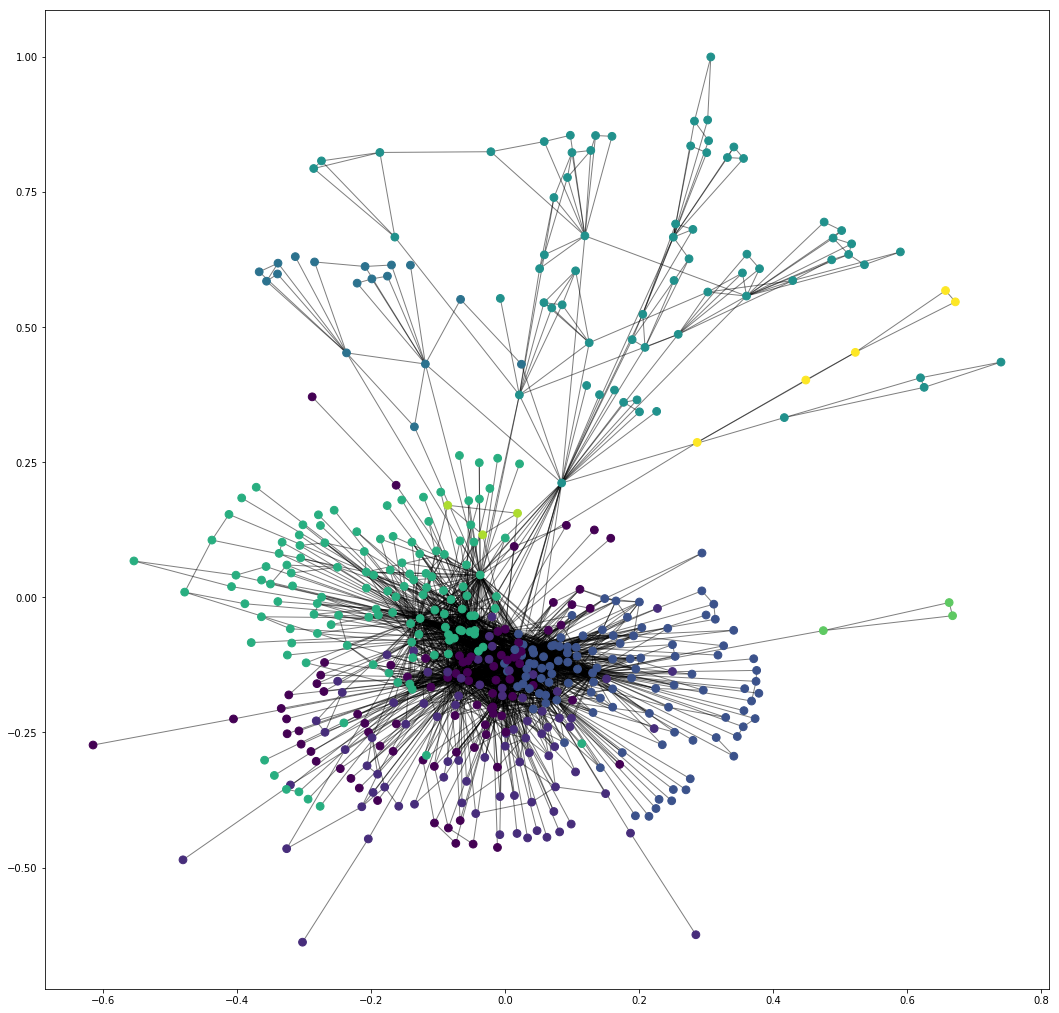

(<matplotlib.collections.LineCollection at 0x7f8fbcd31080>, 0.3673101446053238)

In [968]:
my_partition(air2)

In [261]:
def my_communities(g):
    partition = community_louvain.best_partition(g) #detecting communities 

    # draw the graph
    pos = nx.spring_layout(g)
    # color the nodes according to their partition
    cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
    #print(partition)    
    dic={}
    for nodes in partition.keys():
        if partition[nodes] in dic.keys(): #value of key
            dic[partition[nodes]].append(nodes)# key appending value
        else:
            dic[partition[nodes]]=[nodes]
    sub={}
    for community in dic.keys():
        sub[community]=g.subgraph(dic[community]) 
        
    len_sub={community:len(sub[community]) for community in sub.keys()}   
    #print(len_sub)
#     plt.figure(figsize=(40,40))   
#     for index,community in enumerate(dic.keys()):
#         plt.subplot(len(sub),1,index+1)
#         r= nx.draw_networkx(sub[community])

    for community in sub.keys():
        if len_sub[community]==max(len_sub.values()): # getting the largest community
            p=sub[community]
            #print(len(sub[community]))
            #d=nx.draw_networkx(p)
            break
    e=nx.to_numpy_matrix(p)
    return p #returning largest community

In [262]:
 my_communities(Z)

In [263]:
def my_communities2(g):
    partition = community_louvain.best_partition(g)

    # draw the graph
    pos = nx.spring_layout(g)
    # color the nodes according to their partition
    cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
    #print(partition)    
    dic={}
    for nodes in partition.keys():
        if partition[nodes] in dic.keys(): #value of key
            dic[partition[nodes]].append(nodes)# key appending value
        else:
            dic[partition[nodes]]=[nodes]
    sub={}
    for community in dic.keys():
        sub[community]=g.subgraph(dic[community]) 
        
    len_sub={community:len(sub[community]) for community in sub.keys()}   
    #print(len_sub)
#     plt.figure(figsize=(40,40))   
#     for index,community in enumerate(dic.keys()):
#         plt.subplot(len(sub),1,index+1)
#         r= nx.draw_networkx(sub[community])

    for community in sub.keys():
        if len_sub[community]==max(len_sub.values()): # getting the largest community
            p=sub[community]
            #print(len(sub[community]))
            #d=nx.draw_networkx(p)
            break
    t=nx.degree_centrality(p) #infecting  nodes with highest deg
    sorted_tuples = sorted(t.items(), key=operator.itemgetter(1),reverse=True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    l=list(sorted_dict.keys()) 
    q=l[0] # averaging on 5 graphs starting at different  nodes
    s=[]
    #for i in q: #ndls
    m=100
    gamma=.08
    beta=.14
    init = np.zeros(len(matrix(g)))
    init[0] = 1
    t,p1 = trial(matrix(g),gamma,beta,m,init)
    s.append(t)
    c=np.mean(s, axis=0)
    r=plt.plot(range(m),t/len(matrix(g)),'cyan',label=('population', round(max(t/len(matrix(g))),2)))
    plt.legend() 
    plt.xlabel('timesteps')
    plt.ylabel('fraction of infectives')
    return r
    

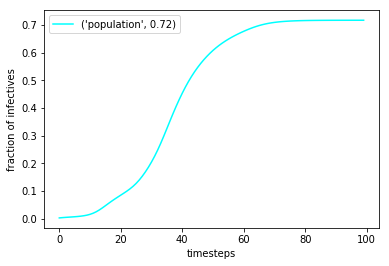

In [264]:
my_communities2(G)

In [265]:
def epidemicom(g): # infecting the largest community
    
    m=100
    gamma=.08
    beta=.14
    init = np.zeros(len(matrix(my_communities(g))))
    init[0] = 1
    t,p1 = trial(matrix(my_communities(g)),gamma,beta,m,init)
    print(t/len(matrix(my_communities(g))))
    print(len(matrix(my_communities(g))))
    a=plt.plot(range(m),t/len(matrix(my_communities(g))),'x',label=('community',round(max(t/len(matrix(my_communities(g)))),2)))
    b=plt.legend()
    plt.xlabel('timesteps')
    plt.ylabel('fraction of infectives')
    return a,b

[0.125      0.1325     0.15100264 0.17766427 0.21054064 0.24808583
 0.28882428 0.33122162 0.37371501 0.41484082 0.45338519 0.4884919
 0.51969344 0.54686952 0.57016188 0.58987903 0.60641375 0.620183
 0.63159006 0.64100402 0.64875099 0.65511252 0.6603279  0.66459834
 0.66809167 0.67094717 0.67327992 0.67518473 0.67673953 0.67800825
 0.67904328 0.6798875  0.68057599 0.68113739 0.68159513 0.68196831
 0.68227254 0.68252053 0.68272268 0.68288746 0.68302176 0.68313123
 0.68322045 0.68329317 0.68335244 0.68340074 0.68344011 0.6834722
 0.68349835 0.68351966 0.68353703 0.68355119 0.68356272 0.68357212
 0.68357979 0.68358603 0.68359112 0.68359527 0.68359865 0.68360141
 0.68360365 0.68360548 0.68360697 0.68360819 0.68360918 0.68360998
 0.68361064 0.68361118 0.68361162 0.68361197 0.68361226 0.6836125
 0.68361269 0.68361285 0.68361298 0.68361308 0.68361317 0.68361324
 0.68361329 0.68361334 0.68361338 0.68361341 0.68361343 0.68361345
 0.68361347 0.68361348 0.68361349 0.6836135  0.68361351 0.68361351


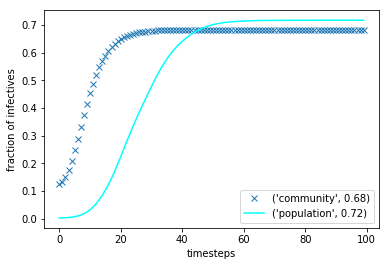

In [338]:
epidemicom(my_communities(G))
my_communities2(G)

[0.03703704 0.05481481 0.08336401 0.12666742 0.18667655 0.26107666
 0.34212031 0.41927409 0.48468784 0.53613605 0.57539215 0.60537667
 0.62863303 0.64700475 0.66175821 0.67376373 0.68363272 0.69180711
 0.69861557 0.70430896 0.70908313 0.71309398 0.71646761 0.71930733
 0.72169862 0.7237127  0.72540922 0.72683829 0.7280421  0.72905621
 0.72991058 0.73063046 0.73123714 0.73174853 0.73217971 0.73254339
 0.73285023 0.73310921 0.73332789 0.73351262 0.73366873 0.7338007
 0.73391233 0.73400678 0.73408674 0.73415445 0.73421181 0.73426043
 0.73430164 0.7343366  0.73436626 0.73439143 0.7344128  0.73443095
 0.73444637 0.73445947 0.7344706  0.73448007 0.73448811 0.73449496
 0.73450078 0.73450573 0.73450995 0.73451354 0.73451659 0.73451919
 0.73452141 0.73452329 0.7345249  0.73452626 0.73452743 0.73452842
 0.73452927 0.73452999 0.7345306  0.73453113 0.73453157 0.73453195
 0.73453228 0.73453255 0.73453279 0.73453299 0.73453316 0.73453331
 0.73453343 0.73453354 0.73453363 0.7345337  0.73453377 0.73453

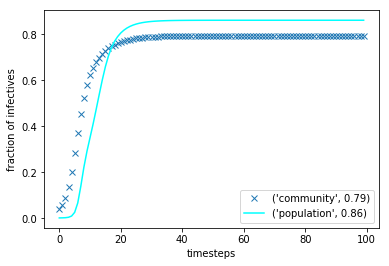

In [342]:
epidemicom(my_communities(D))
my_communities2(D)

[0.09090909 0.21090909 0.39706446 0.62305373 0.80988835 0.91047158
 0.94983273 0.96312296 0.96744207 0.96885189 0.96931985 0.96947813
 0.96953263 0.96955169 0.96955845 0.96956088 0.96956176 0.96956208
 0.9695622  0.96956224 0.96956226 0.96956227 0.96956227 0.96956227
 0.96956227 0.96956227 0.96956227 0.96956227 0.96956227 0.96956227
 0.96956227 0.96956227 0.96956227 0.96956227 0.96956227 0.96956227
 0.96956227 0.96956227 0.96956227 0.96956227 0.96956227 0.96956227
 0.96956227 0.96956227 0.96956227 0.96956227 0.96956227 0.96956227
 0.96956227 0.96956227 0.96956227 0.96956227 0.96956227 0.96956227
 0.96956227 0.96956227 0.96956227 0.96956227 0.96956227 0.96956227
 0.96956227 0.96956227 0.96956227 0.96956227 0.96956227 0.96956227
 0.96956227 0.96956227 0.96956227 0.96956227 0.96956227 0.96956227
 0.96956227 0.96956227 0.96956227 0.96956227 0.96956227 0.96956227
 0.96956227 0.96956227 0.96956227 0.96956227 0.96956227 0.96956227
 0.96956227 0.96956227 0.96956227 0.96956227 0.96956227 0.9695

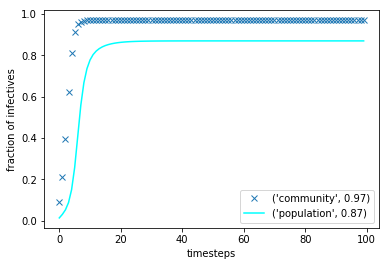

In [284]:
epidemicom(my_communities(F))
my_communities2(F)

[0.11111111 0.13333333 0.16338119 0.20786541 0.27140096 0.3551201
 0.45411417 0.55684879 0.64940157 0.7223881  0.77421147 0.80865055
 0.83087525 0.84519476 0.85456857 0.86085987 0.86520244 0.86828281
 0.87052165 0.87218247 0.873435   0.87439188 0.87513018 0.87570415
 0.87615291 0.87650528 0.87678289 0.87700214 0.87717564 0.87731315
 0.87742225 0.87750891 0.8775778  0.87763259 0.8776762  0.87771092
 0.87773857 0.87776061 0.87777817 0.87779218 0.87780334 0.87781225
 0.87781935 0.87782502 0.87782954 0.87783315 0.87783603 0.87783833
 0.87784016 0.87784162 0.87784279 0.87784373 0.87784447 0.87784507
 0.87784554 0.87784592 0.87784623 0.87784647 0.87784666 0.87784681
 0.87784694 0.87784704 0.87784712 0.87784718 0.87784723 0.87784727
 0.8778473  0.87784733 0.87784735 0.87784736 0.87784738 0.87784739
 0.87784739 0.8778474  0.87784741 0.87784741 0.87784741 0.87784742
 0.87784742 0.87784742 0.87784742 0.87784742 0.87784742 0.87784742
 0.87784742 0.87784742 0.87784743 0.87784743 0.87784743 0.87784

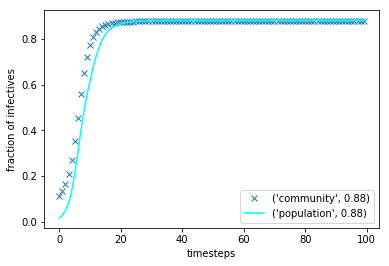

In [317]:
epidemicom(my_communities(Z))
my_communities2(Z)

[0.16666667 0.24666667 0.3168733  0.37974914 0.43675724 0.48846008
 0.53490754 0.57600375 0.61173964 0.64228825 0.66800318 0.68936741
 0.70692906 0.72124537 0.73284321 0.74219634 0.74971573 0.75574883
 0.76058396 0.7644572  0.76756001 0.77004663 0.77204075 0.77364126
 0.77492712 0.77596126 0.77679387 0.77746497 0.77800648 0.77844391
 0.77879764 0.77908398 0.77931599 0.77950416 0.77965691 0.77978102
 0.77988194 0.77996405 0.78003093 0.78008542 0.78012985 0.7801661
 0.78019569 0.78021986 0.78023961 0.78025575 0.78026896 0.78027976
 0.7802886  0.78029584 0.78030177 0.78030663 0.78031061 0.78031387
 0.78031655 0.78031874 0.78032054 0.78032201 0.78032322 0.78032422
 0.78032503 0.7803257  0.78032625 0.7803267  0.78032707 0.78032738
 0.78032763 0.78032783 0.780328   0.78032814 0.78032825 0.78032835
 0.78032842 0.78032849 0.78032854 0.78032858 0.78032862 0.78032864
 0.78032867 0.78032869 0.7803287  0.78032872 0.78032873 0.78032874
 0.78032874 0.78032875 0.78032875 0.78032876 0.78032876 0.78032

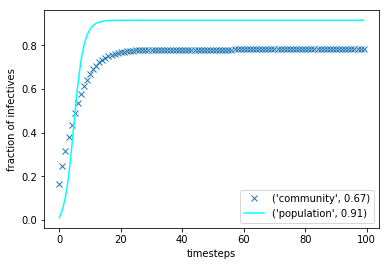

In [282]:
epidemicom(my_communities(BA))
my_communities2(BA)

[0.05       0.067      0.08432199 0.10356224 0.12581794 0.15176623
 0.18165112 0.21521421 0.25163241 0.28954401 0.32722503 0.36290538
 0.39512232 0.42296907 0.44615274 0.46488184 0.47967404 0.49117319
 0.5000211  0.50678866 0.5119506  0.5158856  0.51888809 0.52118341
 0.52294252 0.52429456 0.52533687 0.5261429  0.52676813 0.52725457
 0.52763411 0.52793108 0.52816404 0.52834724 0.52849165 0.52860572
 0.52869601 0.52876761 0.52882449 0.52886975 0.5289058  0.52893457
 0.52895756 0.52897594 0.52899065 0.52900245 0.5290119  0.52901949
 0.52902559 0.52903049 0.52903443 0.5290376  0.52904015 0.52904221
 0.52904386 0.5290452  0.52904627 0.52904714 0.52904784 0.52904841
 0.52904886 0.52904923 0.52904953 0.52904976 0.52904996 0.52905011
 0.52905024 0.52905034 0.52905042 0.52905049 0.52905055 0.52905059
 0.52905062 0.52905065 0.52905067 0.52905069 0.52905071 0.52905072
 0.52905073 0.52905074 0.52905074 0.52905075 0.52905075 0.52905076
 0.52905076 0.52905076 0.52905076 0.52905077 0.52905077 0.5290

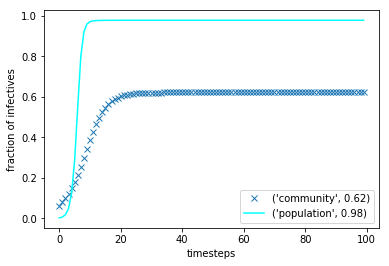

In [286]:
epidemicom(my_communities(ER))
my_communities2(ER)

[0.02083333 0.025      0.04829977 0.10192531 0.207356   0.36475152
 0.5235812  0.63987772 0.71814778 0.77313887 0.81352766 0.84400109
 0.86736615 0.88546755 0.89959334 0.91067738 0.91941311 0.92632364
 0.93180798 0.93617304 0.93965637 0.94244282 0.94467683 0.94647175
 0.94791676 0.9490823  0.95002412 0.95078649 0.95140462 0.9519066
 0.95231486 0.9526474  0.95291862 0.95314013 0.95332128 0.95346959
 0.95359116 0.95369093 0.95377289 0.95384029 0.95389578 0.95394149
 0.95397919 0.9540103  0.954036   0.95405725 0.95407483 0.95408938
 0.95410144 0.95411143 0.95411973 0.95412661 0.95413232 0.95413707
 0.95414102 0.9541443  0.95414704 0.95414931 0.95415121 0.95415279
 0.9541541  0.9541552  0.95415612 0.95415688 0.95415752 0.95415805
 0.95415849 0.95415887 0.95415918 0.95415944 0.95415965 0.95415983
 0.95415999 0.95416011 0.95416022 0.95416031 0.95416038 0.95416044
 0.9541605  0.95416054 0.95416058 0.95416061 0.95416063 0.95416065
 0.95416067 0.95416069 0.9541607  0.95416071 0.95416072 0.95416

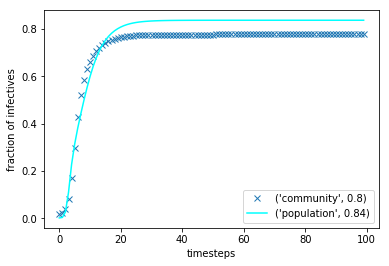

In [304]:
epidemicom(my_communities(air2))
my_communities2(air2)

In [1695]:
print(round(np.real(max(np.linalg.eigvals(matrix(my_communities(G)))))),2)
print(round(np.real(max(np.linalg.eigvals(matrix(my_communities(D)))))),2)
print(round(np.real(max(np.linalg.eigvals(matrix(my_communities(Z)))))),2)
print(round(np.real(max(np.linalg.eigvals(matrix(my_communities(F)))))),2)

3.0 2
13.0 2
6.0 2
10.0 2


In [320]:
def leaf(g):
    leafs=[]
    for i in dict(g.degree()).values():
        if i==1:
            leafs.append(i)
    return len(leafs)/g.number_of_nodes()

In [321]:
leaf(G)

0.6419753086419753

In [322]:
leaf(D)

0.23863636363636365

In [1790]:
leaf(Z)

0.14516129032258066

In [1791]:
leaf(F)

0.22077922077922077

In [323]:
leaf(ER)

0.002

In [1793]:
leaf(BA)

0.0

In [1794]:
leaf(rd)

0.17659574468085107

In [1795]:
leaf(air2)

0.15694164989939638

In [1801]:
nx.transitivity(ER)

0.013327554447935855

# connectivity-nodes

In [1865]:
nx.average_node_connectivity(G)

1.0202193938004052

In [1866]:
nx.average_node_connectivity(BA)

3.818989898989899

In [1885]:
nx.average_node_connectivity(ER)

4.699430861723447

In [1884]:
nx.average_node_connectivity(D)

1.4314961461302924

In [1869]:
nx.average_node_connectivity(Z)

3.0634584875727127

In [166]:
def remove_hub(g):
    deg=np.array(list(dict(g.degree()).values())).astype(float) 
    deg_sort=sorted(deg, reverse=True)#sorting degrees
    mx=deg_sort[:int(0.0*len(g.nodes()))]# 10% of nodes
    a=[]
    for nodes in g.nodes(): # returning hubs
        if g.degree(nodes) in mx:
            a.append(nodes) 
    
    
    gnow=g.copy()
    gnow.remove_nodes_from(a) #removing hubs

    A=nx.to_numpy_matrix(gnow)
    gnow=nx.from_numpy_matrix(A)
    return round(max(np.linalg.eigvals(A)).real,3)

In [72]:
def remove_hubsa(g):
    deg=np.array(list(dict(g.degree()).values())).astype(float) 
    deg_sort=sorted(deg, reverse=True)#sorting degrees
    mx=deg_sort[:int(0.05*len(g.nodes()))]# 10% of nodes
    a=[]
    for nodes in g.nodes(): # returning hubs
        if g.degree(nodes) in mx:
            a.append(nodes) 
    
    
    gnow=g.copy()
    gnow.remove_nodes_from(a) #removing hubs

    A=nx.to_numpy_matrix(gnow)
    gnow=nx.from_numpy_matrix(A)
    return round(max(np.linalg.eigvals(A)).real,3)

In [73]:
def remove_hubsb(g):
    deg=np.array(list(dict(g.degree()).values())).astype(float) 
    deg_sort=sorted(deg, reverse=True)#sorting degrees
    mx=deg_sort[:int(0.1*len(g.nodes()))]# 10% of nodes
    a=[]
    for nodes in g.nodes(): # returning hubs
        if g.degree(nodes) in mx:
            a.append(nodes) 
    
    
    gnow=g.copy()
    gnow.remove_nodes_from(a) #removing hubs

    A=nx.to_numpy_matrix(gnow)
    gnow=nx.from_numpy_matrix(A)
    return  round(max(np.linalg.eigvals(A)).real,3)

In [74]:
def remove_hubsc(g):
    deg=np.array(list(dict(g.degree()).values())).astype(float) 
    deg_sort=sorted(deg, reverse=True)#sorting degrees
    mx=deg_sort[:int(0.15*len(g.nodes()))]# 10% of nodes
    a=[]
    for nodes in g.nodes(): # returning hubs
        if g.degree(nodes) in mx:
            a.append(nodes) 
    
    
    gnow=g.copy()
    gnow.remove_nodes_from(a) #removing hubs

    A=nx.to_numpy_matrix(gnow)
    gnow=nx.from_numpy_matrix(A)
    return round(max(np.linalg.eigvals(A)).real,3)

In [75]:
def remove_hubsd(g):
    deg=np.array(list(dict(g.degree()).values())).astype(float) 
    deg_sort=sorted(deg, reverse=True)#sorting degrees
    mx=deg_sort[:int(0.2*len(g.nodes()))]# 10% of nodes
    a=[]
    for nodes in g.nodes(): # returning hubs
        if g.degree(nodes) in mx:
            a.append(nodes) 
    
    
    gnow=g.copy()
    gnow.remove_nodes_from(a) #removing hubs

    A=nx.to_numpy_matrix(gnow)
    gnow=nx.from_numpy_matrix(A)
    return  round(max(np.linalg.eigvals(A)).real,3)

In [76]:
def remove_hubse(g):
    deg=np.array(list(dict(g.degree()).values())).astype(float) 
    deg_sort=sorted(deg, reverse=True)#sorting degrees
    mx=deg_sort[:int(0.25*len(g.nodes()))]# 10% of nodes
    a=[]
    for nodes in g.nodes(): # returning hubs
        if g.degree(nodes) in mx:
            a.append(nodes) 
    
    
    gnow=g.copy()
    gnow.remove_nodes_from(a) #removing hubs

    A=nx.to_numpy_matrix(gnow)
    gnow=nx.from_numpy_matrix(A)
    return  round(max(np.linalg.eigvals(A)).real,3)

In [77]:
def remove_hubsf(g):
    deg=np.array(list(dict(g.degree()).values())).astype(float) 
    deg_sort=sorted(deg, reverse=True)#sorting degrees
    mx=deg_sort[:int(0.3*len(g.nodes()))]# 10% of nodes
    a=[]
    for nodes in g.nodes(): # returning hubs
        if g.degree(nodes) in mx:
            a.append(nodes) 
    
    
    gnow=g.copy()
    gnow.remove_nodes_from(a) #removing hubs

    A=nx.to_numpy_matrix(gnow)
    gnow=nx.from_numpy_matrix(A)
    return round(max(np.linalg.eigvals(A)).real,3)

In [78]:
def remove_hubsg(g):
    deg=np.array(list(dict(g.degree()).values())).astype(float) 
    deg_sort=sorted(deg, reverse=True)#sorting degrees
    mx=deg_sort[:int(0.4*len(g.nodes()))]# 10% of nodes
    a=[]
    for nodes in g.nodes(): # returning hubs
        if g.degree(nodes) in mx:
            a.append(nodes) 
    
    
    gnow=g.copy()
    gnow.remove_nodes_from(a) #removing hubs

    A=nx.to_numpy_matrix(gnow)
    gnow=nx.from_numpy_matrix(A)
    return  round(max(np.linalg.eigvals(A)).real,3)

In [79]:
def remove_hubsh(g):
    deg=np.array(list(dict(g.degree()).values())).astype(float) 
    deg_sort=sorted(deg, reverse=True)#sorting degrees
    mx=deg_sort[:int(0.5*len(g.nodes()))]# 10% of nodes
    a=[]
    for nodes in g.nodes(): # returning hubs
        if g.degree(nodes) in mx:
            a.append(nodes) 
    
    
    gnow=g.copy()
    gnow.remove_nodes_from(a) #removing hubs

    A=nx.to_numpy_matrix(gnow)
    gnow=nx.from_numpy_matrix(A)
    return  round(max(np.linalg.eigvals(A)).real,3)

In [169]:
def hubs(g):
    a=(remove_hub(g), remove_hubsa(g), remove_hubsb(g),remove_hubsc(g),remove_hubsd(g),remove_hubse(g),
       remove_hubsf(g),remove_hubsg(g),remove_hubsh(g))
    return a

In [170]:
def hubs2(g):
    a=(remove_hub(g), remove_hubsa(g), remove_hubsb(g),remove_hubsc(g),remove_hubsd(g),remove_hubse(g),
       remove_hubsf(g))
    return a

In [171]:
def thresh2(g):
    w=[]
    r=(beta/gamma)
    d=list(hubs2(g))
    for i in range(len(hubs2(g))):
        s=r*d[i]
        w.append(s)
    return w  

In [172]:
def thresh(g):
    w=[]
    beta=0.14
    gamma=0.08
    r=(beta/gamma)
    d=list(hubs(g))
    for i in range(len(hubs(g))):
        s=r*d[i]
        w.append(s)
    return w  

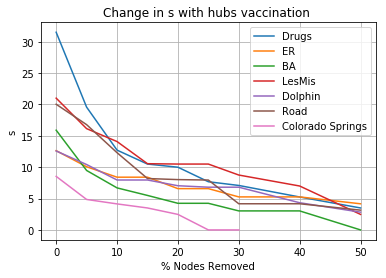

In [174]:
x=[0,5,10,15,20,25,30,40,50]
x2=[0,5,10,15,20,25,30]
#y1 = thresh(air2)
plt.plot(x,thresh(D),label=("Drugs"))
#plt.plot(x,thresh(air2),label=("air"))
plt.plot(x,thresh(ER),label=("ER"))
plt.plot(x,thresh(BA),label=("BA"))
plt.plot(x,thresh(F),label=("LesMis"))
plt.plot(x,thresh(Z),label=("Dolphin"))
plt.plot(x,thresh(rd),label=("Road"))
plt.plot(x2,thresh2(G),label=("Colorado Springs"))

  
plt.xlabel('% Nodes Removed')
plt.ylabel('s')
  

plt.title('Change in s with hubs vaccination ')
plt.legend() 
plt.grid()
plt.show()

In [176]:
def max_edge_btwna(g): #removing 10% edges with highest edge betweenness
    d=nx.edge_betweenness_centrality(g)
    sorted_tuples = sorted(d.items(), key=operator.itemgetter(1),reverse=True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    e=list(sorted_dict.keys()) 

    t=e[:int(0*len(g.edges()))] #10% edges with highest edge betweenness
    
    k=g.copy()
    k.remove_edges_from(t)
    A=nx.to_numpy_matrix(k)
    return  round(max(np.linalg.eigvals(A)).real,3)

In [189]:
def max_edge_btwnb(g): #removing 10% edges with highest edge betweenness
    d=nx.edge_betweenness_centrality(g)
    sorted_tuples = sorted(d.items(), key=operator.itemgetter(1),reverse=True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    e=list(sorted_dict.keys()) 

    t=e[:int(0.05*len(g.edges()))] #10% edges with highest edge betweenness
    
    k=g.copy()
    k.remove_edges_from(t)
    A=nx.to_numpy_matrix(k)
    return  round(max(np.linalg.eigvals(A)).real,3)

In [190]:
def max_edge_btwnc(g): #removing 10% edges with highest edge betweenness
    d=nx.edge_betweenness_centrality(g)
    sorted_tuples = sorted(d.items(), key=operator.itemgetter(1),reverse=True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    e=list(sorted_dict.keys()) 

    t=e[:int(0.1*len(g.edges()))] #10% edges with highest edge betweenness
    
    k=g.copy()
    k.remove_edges_from(t)
    A=nx.to_numpy_matrix(k)
    return  round(max(np.linalg.eigvals(A)).real,3)

In [191]:
def max_edge_btwnd(g): #removing 10% edges with highest edge betweenness
    d=nx.edge_betweenness_centrality(g)
    sorted_tuples = sorted(d.items(), key=operator.itemgetter(1),reverse=True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    e=list(sorted_dict.keys()) 

    t=e[:int(0.15*len(g.edges()))] #10% edges with highest edge betweenness
    
    k=g.copy()
    k.remove_edges_from(t)
    A=nx.to_numpy_matrix(k)
    return  round(max(np.linalg.eigvals(A)).real,3)

In [192]:
def max_edge_btwne(g): #removing 10% edges with highest edge betweenness
    d=nx.edge_betweenness_centrality(g)
    sorted_tuples = sorted(d.items(), key=operator.itemgetter(1),reverse=True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    e=list(sorted_dict.keys()) 

    t=e[:int(0.2*len(g.edges()))] #10% edges with highest edge betweenness
    
    k=g.copy()
    k.remove_edges_from(t)
    A=nx.to_numpy_matrix(k)
    return  round(max(np.linalg.eigvals(A)).real,3)

In [193]:
def max_edge_btwnf(g): #removing 10% edges with highest edge betweenness
    d=nx.edge_betweenness_centrality(g)
    sorted_tuples = sorted(d.items(), key=operator.itemgetter(1),reverse=True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    e=list(sorted_dict.keys()) 

    t=e[:int(0.3*len(g.edges()))] #10% edges with highest edge betweenness
    
    k=g.copy()
    k.remove_edges_from(t)
    A=nx.to_numpy_matrix(k)
    return  round(max(np.linalg.eigvals(A)).real,3)

In [194]:
def max_edge_btwng(g): #removing 10% edges with highest edge betweenness
    d=nx.edge_betweenness_centrality(g)
    sorted_tuples = sorted(d.items(), key=operator.itemgetter(1),reverse=True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    e=list(sorted_dict.keys()) 

    t=e[:int(0.5*len(g.edges()))] #10% edges with highest edge betweenness
    
    k=g.copy()
    k.remove_edges_from(t)
    A=nx.to_numpy_matrix(k)
    return  round(max(np.linalg.eigvals(A)).real,3)

In [195]:
def edges(g):
    a=(max_edge_btwna(g),max_edge_btwnb(g),max_edge_btwnc(g),max_edge_btwnd(g),max_edge_btwne(g),
      max_edge_btwnf(g),max_edge_btwng(g))
    return a

In [196]:
def thresh3(g):
    w=[]
    beta=0.14
    gamma=0.08
    r=(beta/gamma)
    d=list(edges(g))
    for i in range(len(edges(g))):
        s=r*d[i]
        w.append(s)
    return w  

In [197]:
edges(G)

(4.877, 4.745, 4.357, 4.128, 4.128, 4.049, 3.771)

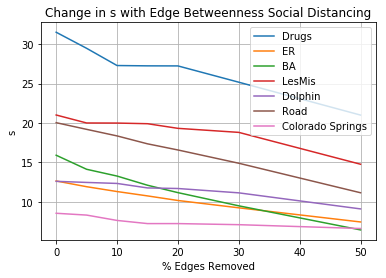

In [202]:
x=[0,5,10,15,20,30,50]
#x2=[0,5,10,15,20,25,30]
#y1 = thresh(air2)
plt.plot(x,thresh3(D),label=("Drugs"))
#plt.plot(x,thresh(air2),label=("air"))
plt.plot(x,thresh3(ER),label=("ER"))
plt.plot(x,thresh3(BA),label=("BA"))
plt.plot(x,thresh3(F),label=("LesMis"))
plt.plot(x,thresh3(Z),label=("Dolphin"))
plt.plot(x,thresh3(rd),label=("Road"))
plt.plot(x,thresh3(G),label=("Colorado Springs"))

  
plt.xlabel('% Edges Removed')
plt.ylabel('s')
  

plt.title('Change in s with Edge Betweenness Social Distancing')
plt.legend() 
plt.grid()
plt.show()

Network	&Hubs Vaccination&	Node Betweenness	&Eigenvector	&Most Connected Edges&	Edge Betweenness\\
Colorado Springs &	1\%&	2\%	&2\%&	12\%	&7\%\\
Drugs   &	4\%	&4\%	&9\%	&45\%	&20\%\\
Dolphin	&23\%	&10\%&	30\%	&61\%&	42\%\\
Les Miserables   & 	10\%&	10\%	&20\%&	50\%&	42\%\\


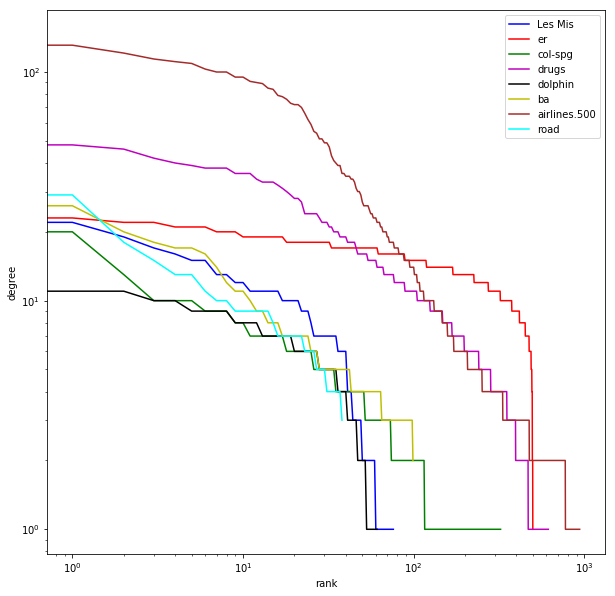

In [89]:
plt.figure(figsize=(10,10))
degree_sequence1 = sorted(dict(nx.degree(F)).values(), reverse=True)
plt.plot(degree_sequence1, 'b-',label='Les Mis')

degree_sequence2 = sorted(dict(nx.degree(ER)).values(), reverse=True)
plt.plot(degree_sequence2, 'r-',label='er')

degree_sequence3 = sorted(dict(nx.degree(G)).values(), reverse=True)
plt.plot(degree_sequence3, 'g',label='col-spg')

degree_sequence4 = sorted(dict(nx.degree(D)).values(), reverse=True)
plt.plot(degree_sequence4, 'm',label='drugs')


degree_sequence5 = sorted(dict(nx.degree(Z)).values(), reverse=True)
plt.plot(degree_sequence5, 'k',label='dolphin')

degree_sequence6 = sorted(dict(nx.degree(BA)).values(), reverse=True)
plt.loglog(degree_sequence6, 'y',label='ba')

degree_sequence7 = sorted(dict(nx.degree(air2)).values(), reverse=True)
plt.plot(degree_sequence7, 'brown',label='airlines.500')

degree_sequence8 = sorted(dict(nx.degree(rd)).values(), reverse=True)
plt.plot(degree_sequence8, 'cyan',label='road')


plt.ylabel("degree")
plt.xlabel("rank")
plt.legend()
plt.show()


https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


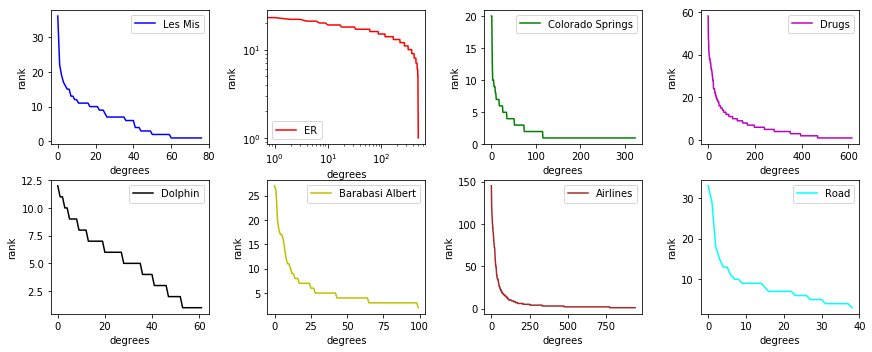

In [130]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 5))
axes[0,0].plot(degree_sequence1, 'b-',label='Les Mis')

plt.ylabel("degree")
plt.xlabel("rank")
plt.legend()
axes[0,1].plot(degree_sequence2, 'r-',label='ER')

plt.ylabel("degree")
plt.xlabel("rank")
plt.legend()
axes[0,2].plot(degree_sequence3, 'g',label='Colorado Springs')

plt.ylabel("degree")
plt.xlabel("rank")
plt.legend()
axes[0,3].plot(degree_sequence4, 'm',label='Drugs')
fig.tight_layout()

plt.ylabel("degree")
plt.xlabel("rank")
plt.legend()

axes[1,0].plot(degree_sequence5, 'k',label='Dolphin')
axes[1,1].plot(degree_sequence6, 'y',label='Barabasi Albert')
axes[1,2].plot(degree_sequence7, 'brown',label='Airlines')
axes[1,3].plot(degree_sequence8, 'cyan',label='Road')

for ax in axes.flat:
    ax.set(xlabel='degrees', ylabel='rank')
    ax.legend()
plt.show()

In [154]:
axes[4].plot(degree_sequence5, 'k',label='dolphin')
axes[5].plot(degree_sequence6, 'y',label='ba')
axes[6].plot(degree_sequence7, 'brown',label='airlines.500')
axes[7].plot(degree_sequence8, 'cyan',label='road')

IndexError: index 4 is out of bounds for axis 0 with size 2

In [95]:
nx.average_degree_connectivity(rd)

{13: 12.038461538461538,
 10: 13.15,
 7: 16.367346938775512,
 9: 13.481481481481481,
 3: 6.0,
 15: 9.466666666666667,
 4: 17.035714285714285,
 33: 7.151515151515151,
 11: 13.818181818181818,
 29: 7.275862068965517,
 8: 12.875,
 5: 19.2,
 18: 7.388888888888889,
 6: 18.083333333333332}

In [103]:
nx.average_node_connectivity(air2)

1.7119071896313416

In [112]:
nx.degree(rd)

DegreeView({'8': 13, '1': 10, '11': 7, '12': 9, '13': 7, '22': 13, '23': 10, '34': 3, '35': 15, '37': 4, '39': 33, '7': 9, '2': 11, '9': 7, '36': 29, '14': 8, '3': 7, '15': 9, '16': 5, '17': 4, '18': 9, '4': 4, '6': 4, '5': 4, '10': 5, '20': 4, '21': 5, '24': 4, '38': 18, '19': 9, '26': 7, '25': 6, '27': 9, '28': 6, '29': 6, '32': 7, '33': 7, '30': 6, '31': 5})

In [111]:
sorted(dict(nx.degree(rd)).values())

[3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 11,
 13,
 13,
 15,
 18,
 29,
 33]

In [128]:
def deg_seq(g):  
    pk=[i/g.number_of_nodes() for i in nx.degree_histogram(g)]
    return pk
   # plt.plot(pk, 'b-',label='Les Mis')



No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


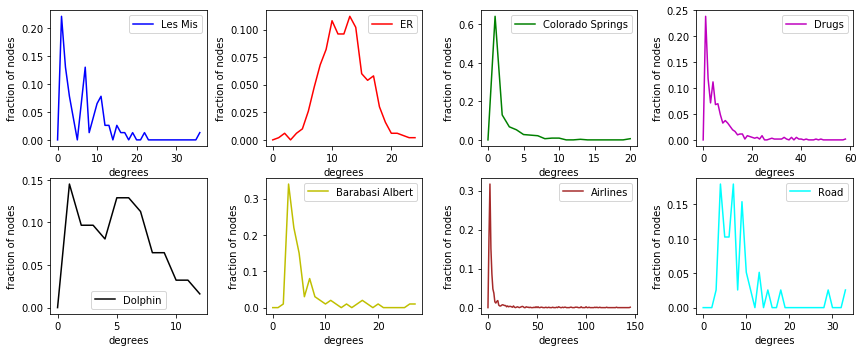

In [135]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 5))
axes[0,0].plot(deg_seq(F), 'b-',label='Les Mis')

plt.ylabel("degree")
plt.xlabel("rank")
plt.legend()
axes[0,1].plot(deg_seq(ER), 'r-',label='ER')

plt.ylabel("degree")
plt.xlabel("rank")
plt.legend()
axes[0,2].plot(deg_seq(G), 'g',label='Colorado Springs')

plt.ylabel("degree")
plt.xlabel("rank")
plt.legend()
axes[0,3].plot(deg_seq(D), 'm',label='Drugs')
fig.tight_layout()

plt.ylabel("degree")
plt.xlabel("rank")
plt.legend()

axes[1,0].plot(deg_seq(Z), 'k',label='Dolphin')
axes[1,1].plot(deg_seq(BA), 'y',label='Barabasi Albert')
axes[1,2].plot(deg_seq(air2), 'brown',label='Airlines')
axes[1,3].plot(deg_seq(rd), 'cyan',label='Road')

for ax in axes.flat:
    ax.set(xlabel='degrees', ylabel='fraction of nodes')
    ax.legend()
plt.show()

In [318]:
ER.number_of_edges()

3014

Network	&Nodes	&Edges&	Average Clustering	&Average Degree&	Shortest Path length&	Density	&Largest Eigenvalue of adjacency matrix	&average node connectivity&	Fraction of leaves on network\\\hline
Colorado Springs &	324	&247&	0.03&	2.14	&8.33&	0.0066&	4.88&	1.02	&0.64\\\hline
Drugs   &	616&	2012	&0.55&	6.53	&5.28	&0.011&	18.01&	1.43&	0.24\\\hline
Dolphin	&62	&15	&0.26	&5.12	&3.36&	0.084&	7.19&	3.06	&0.15\\\hline
Les Miserables  &  	77	&254	&0.573	&6.6	2.64&	0.086	&12.01&	2.26	&0.22\\\hline
Erdos-Renyi    & 	500	&3014&	0.024	&6.08&	2.23	&0.024	&13.27&	10	&0\\\hline
Barabasi-Albert&	100	&291&	0.14&	5.82&	2.57	&0.059	&9.09&	3.82	&0\\\hline
Road	&940	&3446	&0.52	&7.33&	4.13	&0.0007&	45.2&	1.71&	0.18\\\hline
US_largest500 airport network	&497	&2853&	0.6	&11.5&	3.022&	0.023&	46.34	&5.76&	0.16\\\hline
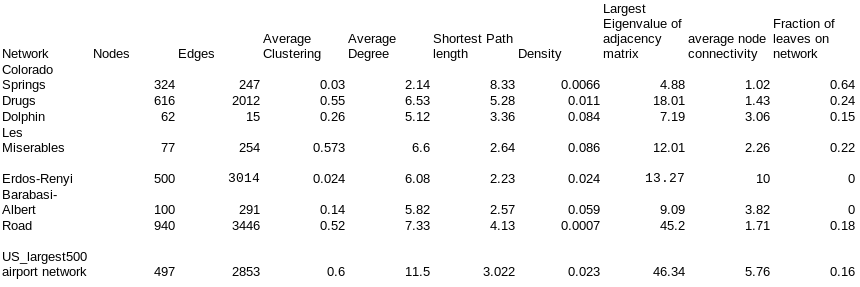